In [ ]:
!pip install transformers datasets


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import load_dataset

# Model ve tokenizer yükleniyor
model_name = "ncoskun/distilbert-emotion-mini-amazon"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import load_dataset, concatenate_datasets

In [9]:
# Duygu analizi için pipeline hazırlanıyor
sentiment_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Hugging Face'ten dataset yükleniyor, belirtilen kategoriler için
dataset_name = "McAuley-Lab/Amazon-Reviews-2023"
categories = [
    "raw_review_Beauty_and_Personal_Care",
    "raw_review_Amazon_Fashion",
    "raw_review_Industrial_and_Scientific",
    "raw_review_Electronics",
    "raw_review_Tools_and_Home_Improvement"
]

# Her kategoriden ilk 100 veriyi yükleyip birleştir
datasets = []
for cat in categories:
    full_data = load_dataset(dataset_name, cat, split="full")
    selected_data = full_data.select(range(100))  # İlk 100 veriyi seç
    datasets.append(selected_data)

# Veri setlerini birleştir
combined_data = concatenate_datasets(datasets)


Generating full split: 0 examples [00:00, ? examples/s]

Generating full split: 0 examples [00:00, ? examples/s]

Generating full split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

Generating full split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [24]:

def add_sentiment(batch):
    # Batch içindeki tüm metinleri tokenleştir ve tensorlere dönüştür
    inputs = tokenizer(batch['text'], padding=True, truncation=True, max_length=512, return_tensors="pt")
    # Model tahminlerini al
    with torch.no_grad():
        outputs = model(**inputs)
    # En yüksek logit değerine sahip sınıfları tahmin et
    predictions = outputs.logits.argmax(dim=-1).tolist()
    # Sınıf etiketlerini al
    sentiment_labels = [model.config.id2label[prediction] for prediction in predictions]
    # Batch'e tahmin sonuçlarını ekle
    batch['predicted_sentiment'] = sentiment_labels
    return batch

# Birleştirilmiş dataset'e duygu analizi sonuçları ekleniyor
data_with_sentiments = combined_data.map(add_sentiment, batched=True, batch_size=16)

In [20]:
# Sonuçları görmek için ilk 5 veriyi yazdır
print(data_with_sentiments[0])

{'rating': 1.0, 'title': 'Gasoline!! Seriously reeks of gasoline!', 'text': 'Opened the package & instant migraine. I cannot believe the stench.  I have purchased other packages that did not smell at all so I do not know if these were a damaged shipment or damaged during packaging or what, but the minute I opened the Amazon package I smelled it before I even opened the Terra Tattoos package. I couldn’t believe it. Then I find that the pink inks from the back have smeared all over the fronts of the tattoos. Yes, you eventually take the clear part off to apply the tattoo, but I always lay it down with the clear covering first to line it up & I didn’t want to risk the pink ink transferring to my art projects so it’s going back. I’ll update the review when Amazon sends my replacement. I’m upset because now my resin is here & I don’t have the tattoos to do my project, but I’m more mad about the fact that I have a massive migraine because of the gasoline fumes that lingered.  I believe they 

# **Data Analysis**

In [21]:
import pandas as pd

# Veri setini DataFrame'e dönüştür
data_df = pd.DataFrame(data_with_sentiments)


In [25]:
# Kategori isimlerini belirt
categories = [
    "raw_review_Beauty_and_Personal_Care",
    "raw_review_Amazon_Fashion",
    "raw_review_Industrial_and_Scientific",
    "raw_review_Electronics",
    "raw_review_Tools_and_Home_Improvement"
]

# Her kategoriden 100'er veri alındığını varsayarak kategori etiketlerini oluştur
category_labels = []
for category in categories:
    category_labels.extend([category] * 100)  # Her kategori için 100 kez kategori adını ekle

# Kategori etiketlerini DataFrame'e ekle
data_df['category'] = category_labels

In [26]:
# Her kategori için duygu durumlarını analiz et
category_sentiments = {}
categories = [
    "raw_review_Beauty_and_Personal_Care",
    "raw_review_Amazon_Fashion",
    "raw_review_Industrial_and_Scientific",
    "raw_review_Electronics",
    "raw_review_Tools_and_Home_Improvement"
]

for category in categories:
    # Kategoriye ait verileri filtrele
    category_data = data_df[data_df['category'] == category]
    # Duygu durumlarının frekansını hesapla
    sentiment_counts = category_data['predicted_sentiment'].value_counts()
    category_sentiments[category] = sentiment_counts

    # Kategori duygu durumlarını yazdır
    print(f"{category} Sentiment Analysis:\n{sentiment_counts}\n")


raw_review_Beauty_and_Personal_Care Sentiment Analysis:
predicted_sentiment
LABEL_3    50
LABEL_0    23
LABEL_2    18
LABEL_1     9
Name: count, dtype: int64

raw_review_Amazon_Fashion Sentiment Analysis:
predicted_sentiment
LABEL_3    36
LABEL_2    30
LABEL_0    18
LABEL_1    16
Name: count, dtype: int64

raw_review_Industrial_and_Scientific Sentiment Analysis:
predicted_sentiment
LABEL_3    47
LABEL_2    30
LABEL_0    16
LABEL_1     7
Name: count, dtype: int64

raw_review_Electronics Sentiment Analysis:
predicted_sentiment
LABEL_3    57
LABEL_2    20
LABEL_0    18
LABEL_1     5
Name: count, dtype: int64

raw_review_Tools_and_Home_Improvement Sentiment Analysis:
predicted_sentiment
LABEL_3    55
LABEL_0    23
LABEL_2    13
LABEL_1     9
Name: count, dtype: int64



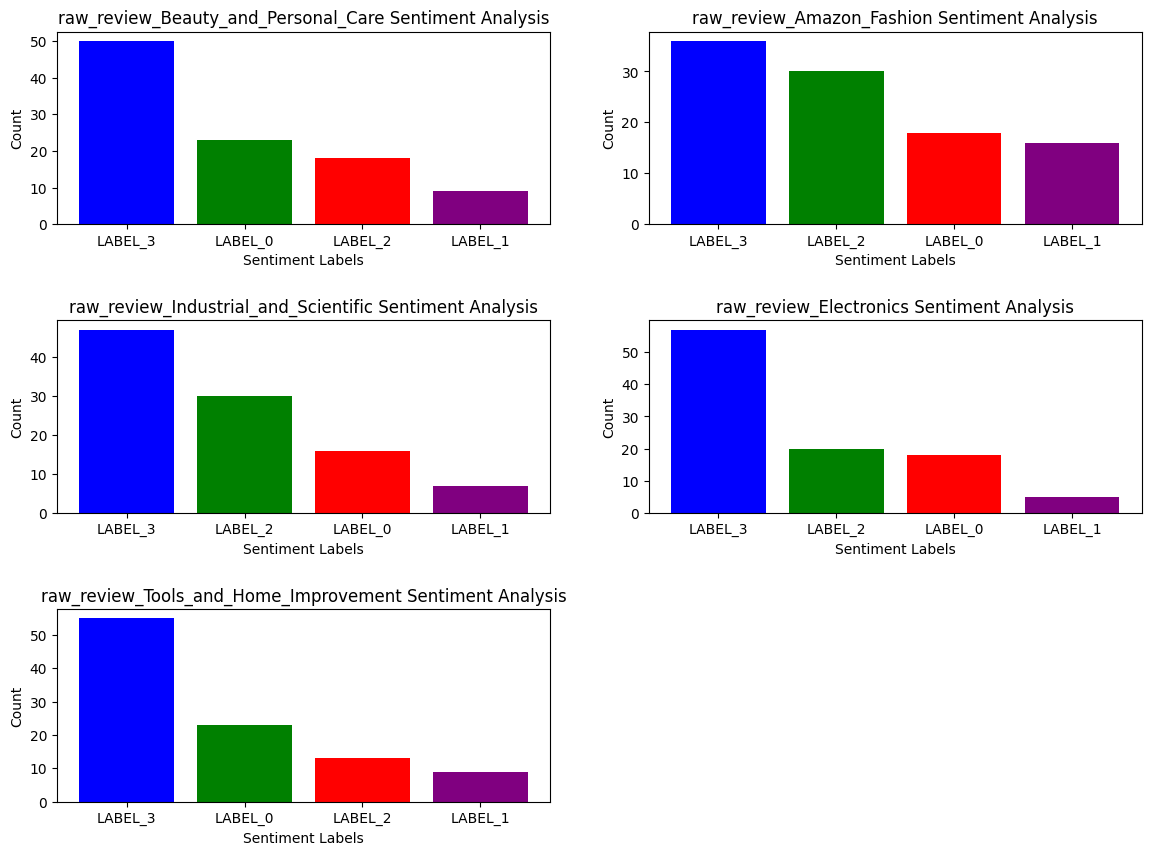

In [27]:
import matplotlib.pyplot as plt

# Grafiği çizdir
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.5)
axes = axes.ravel()

for i, category in enumerate(categories):
    # Kategoriye ait duygu dağılımını al
    sentiment_counts = category_sentiments[category]

    # Çubuk grafiği çizdir
    axes[i].bar(sentiment_counts.index, sentiment_counts.values, color=['blue', 'green', 'red', 'purple'])
    axes[i].set_title(f'{category} Sentiment Analysis')
    axes[i].set_xlabel('Sentiment Labels')
    axes[i].set_ylabel('Count')

# Grafikleri düzenle
plt.delaxes(axes[-1])  # Eksik olan altıncı subplot'u kaldır
plt.show()


Comparison of All Categories:
                      raw_review_Beauty_and_Personal_Care  \
predicted_sentiment                                        
LABEL_0                                               23   
LABEL_1                                                9   
LABEL_2                                               18   
LABEL_3                                               50   

                     raw_review_Amazon_Fashion  \
predicted_sentiment                              
LABEL_0                                     18   
LABEL_1                                     16   
LABEL_2                                     30   
LABEL_3                                     36   

                     raw_review_Industrial_and_Scientific  \
predicted_sentiment                                         
LABEL_0                                                16   
LABEL_1                                                 7   
LABEL_2                                                30   
LA

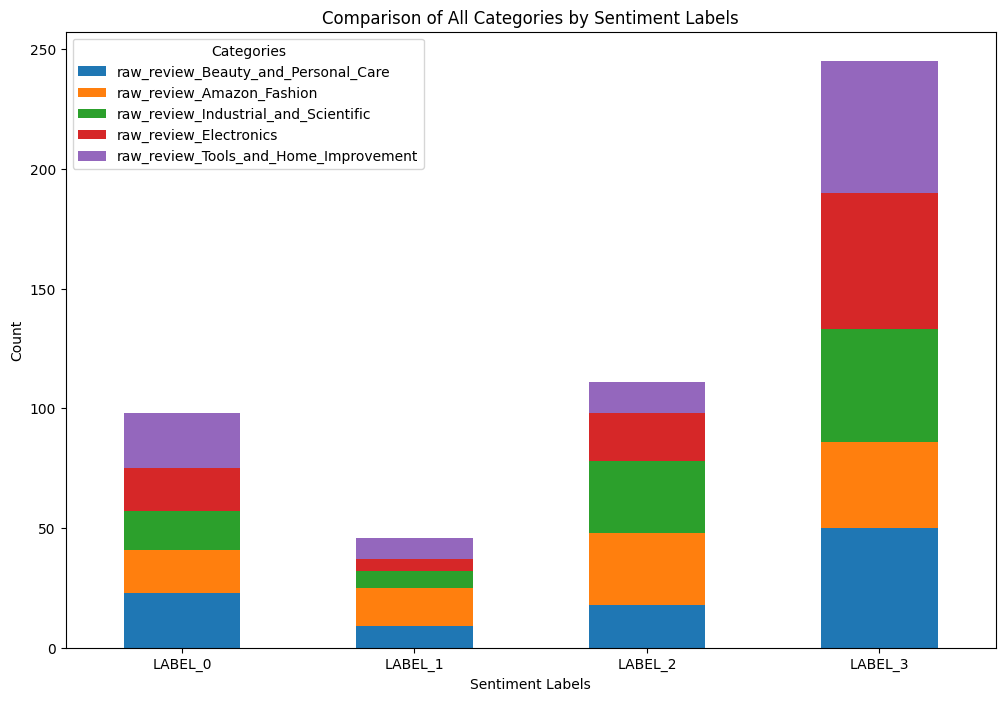

In [29]:
# Tüm kategoriler için duygu durumlarını karşılaştırma tablosu oluştur
comparison_df = pd.DataFrame(category_sentiments)
print("Comparison of All Categories:\n", comparison_df)

# Yığın çubuk grafiği çizdir
comparison_df.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Comparison of All Categories by Sentiment Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Categories')
plt.show()

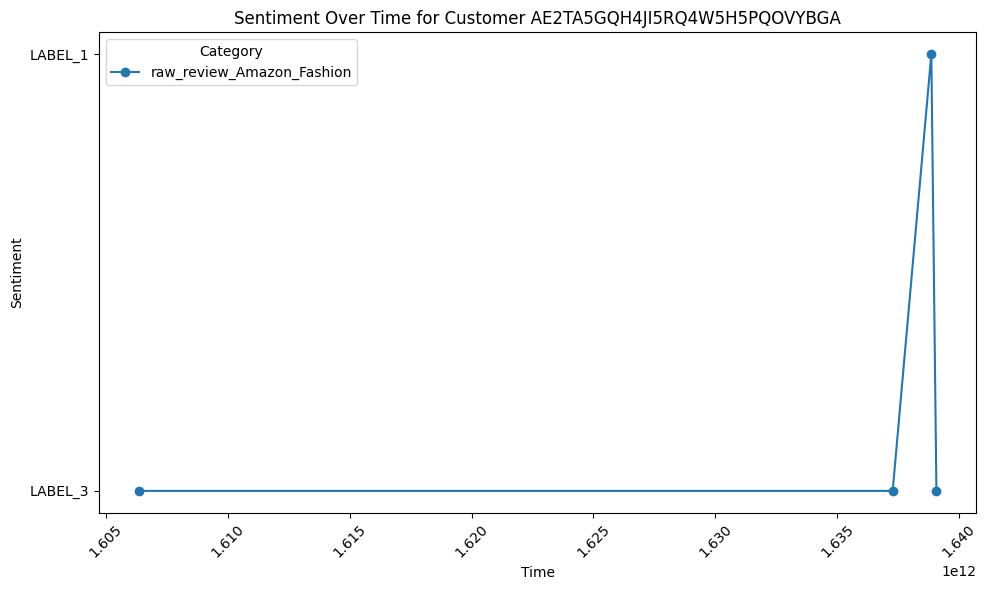

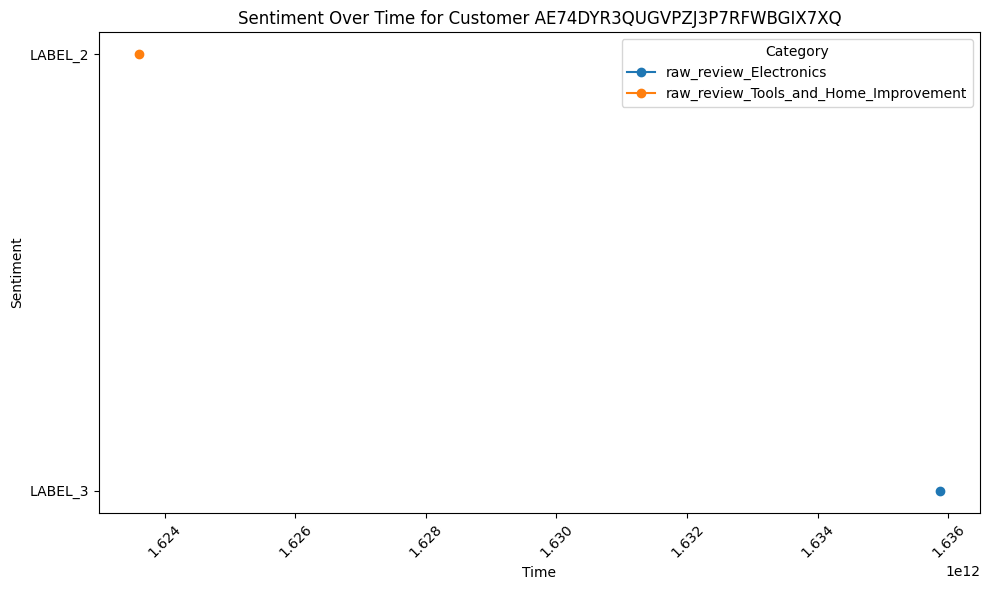

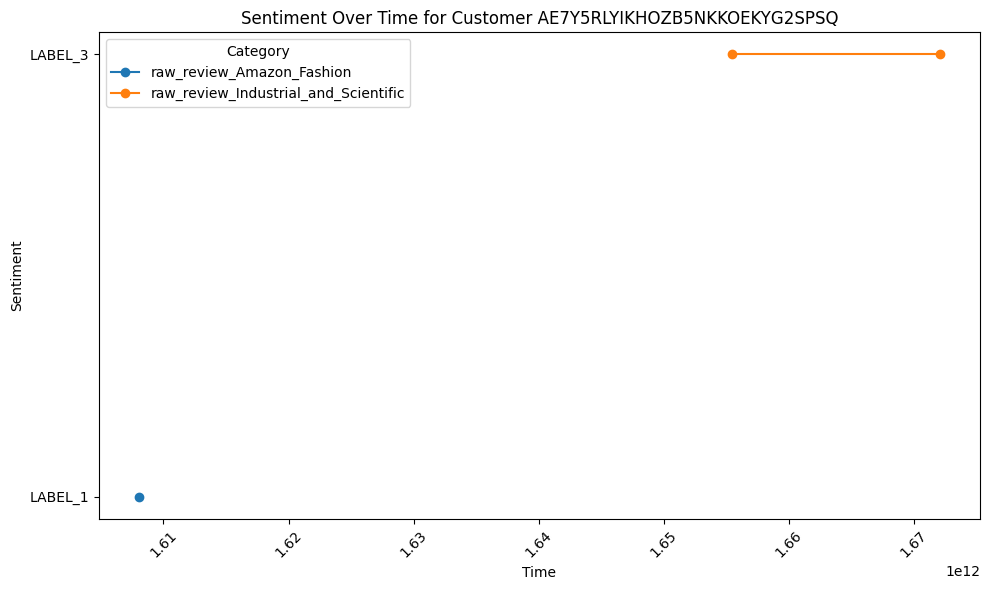

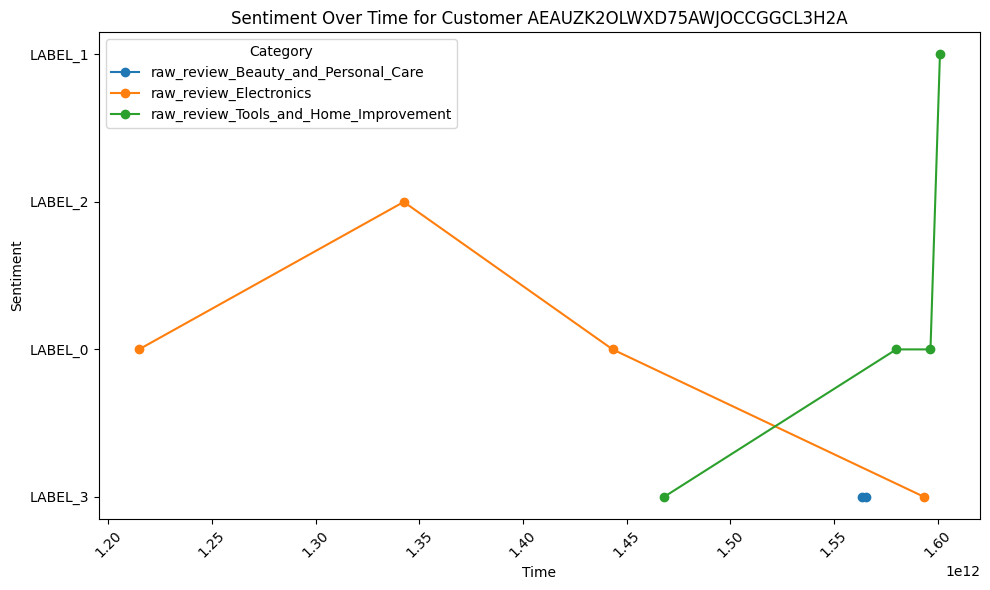

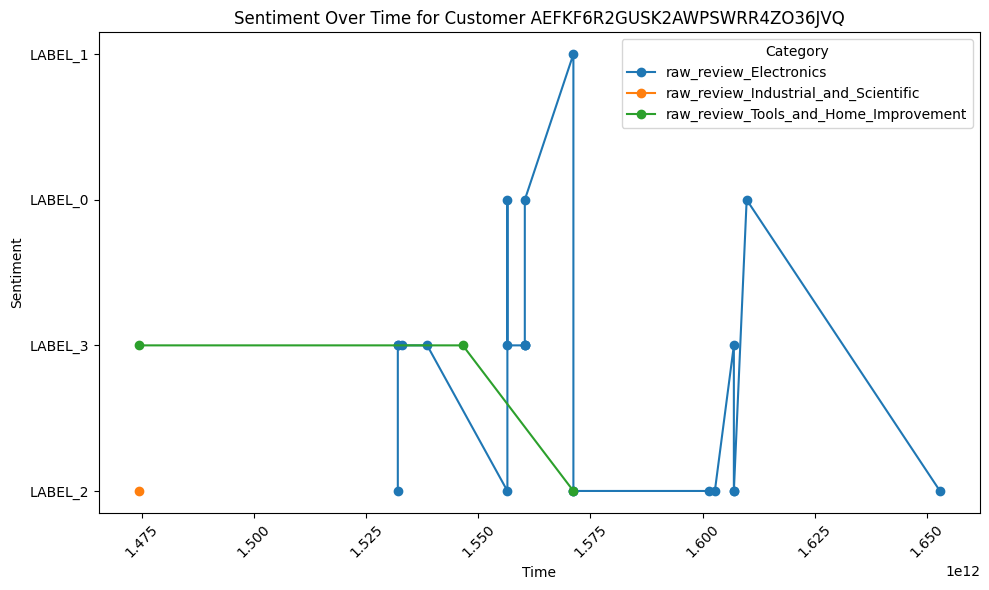

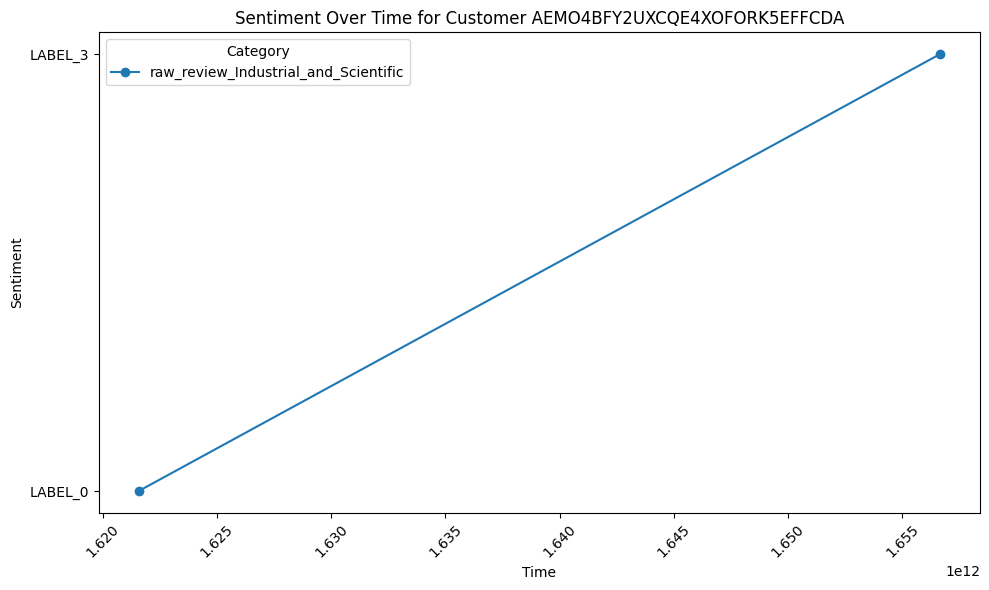

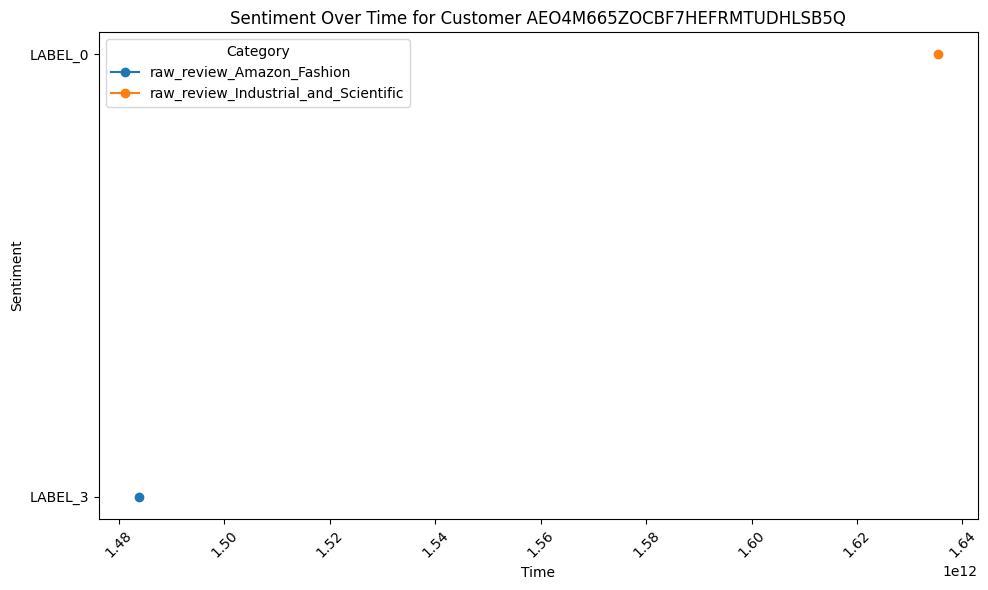

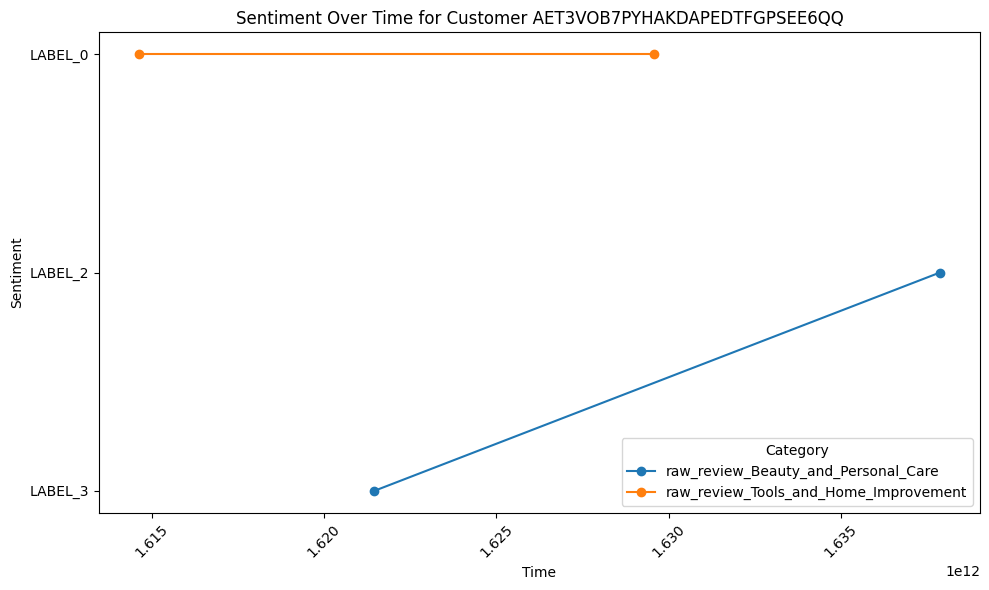

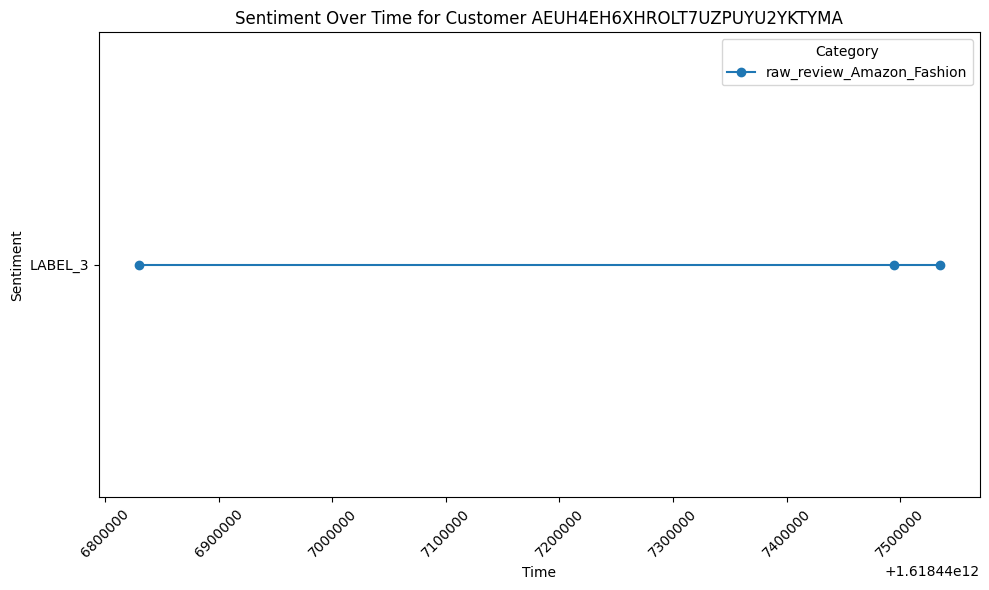

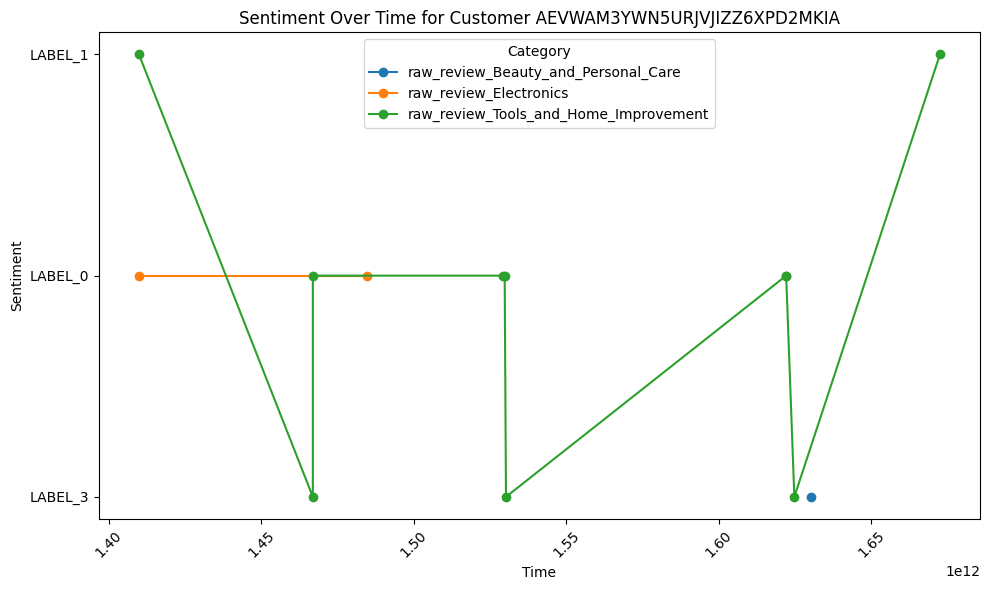

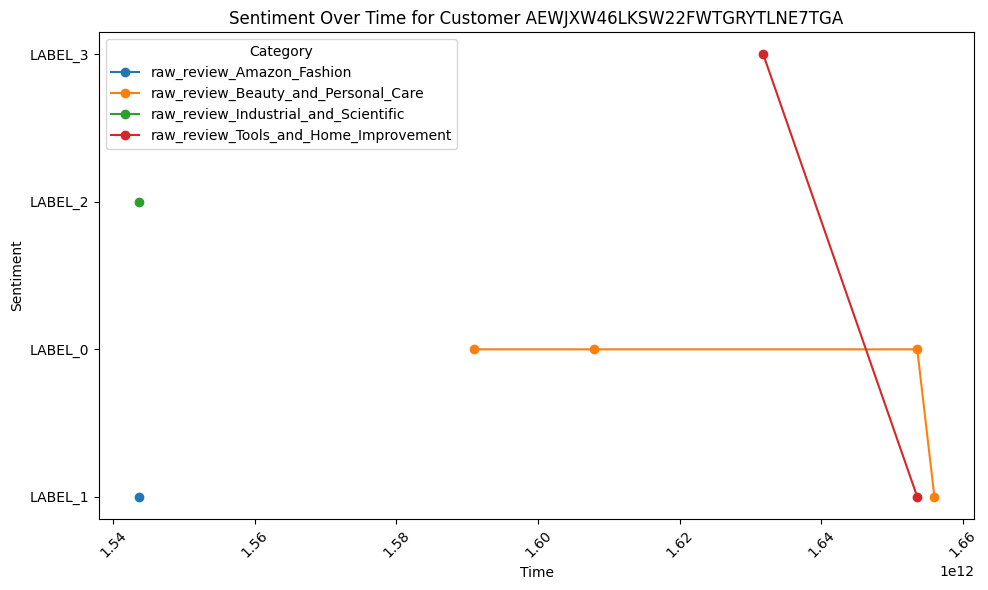

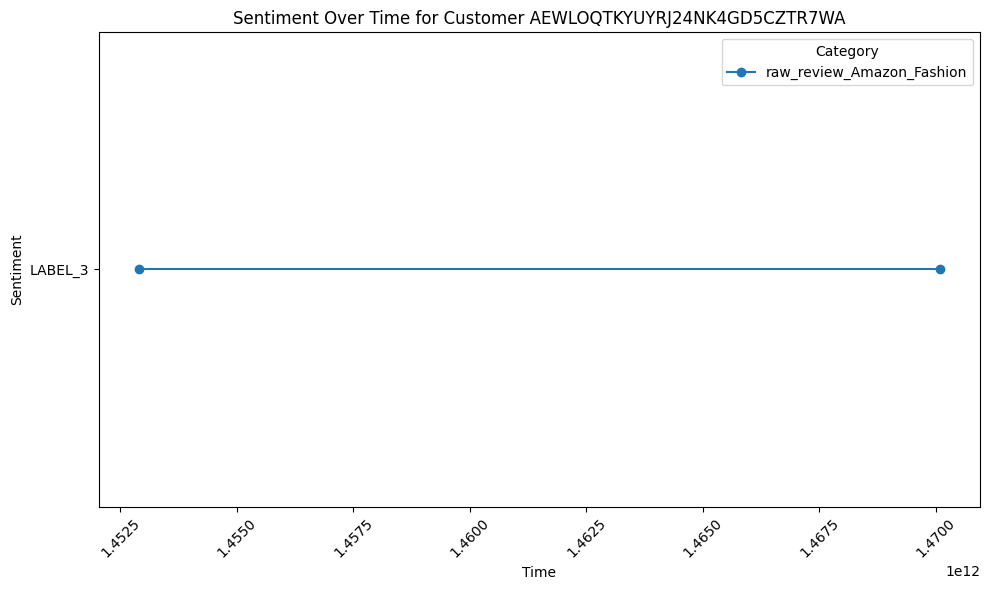

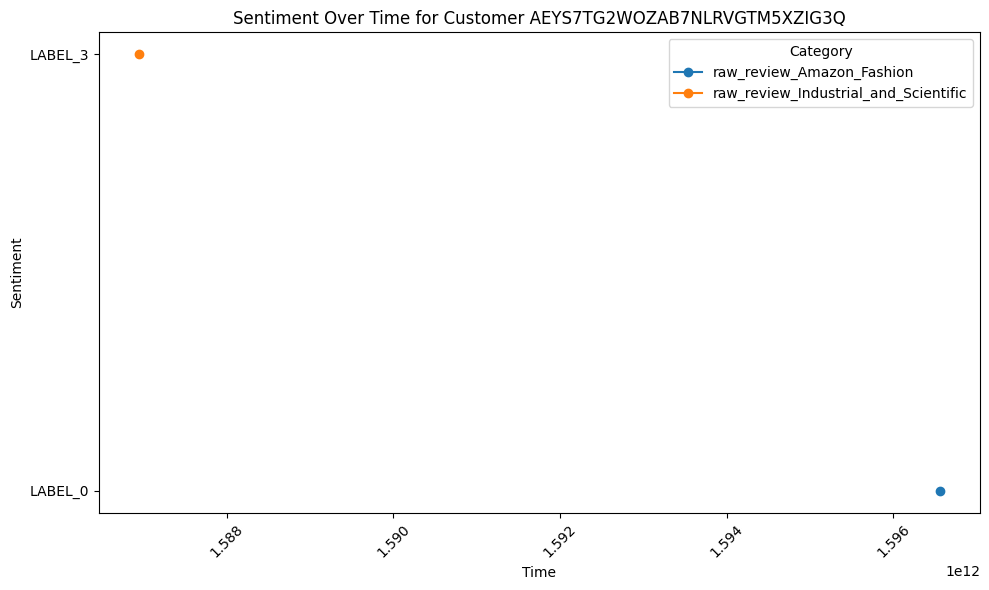

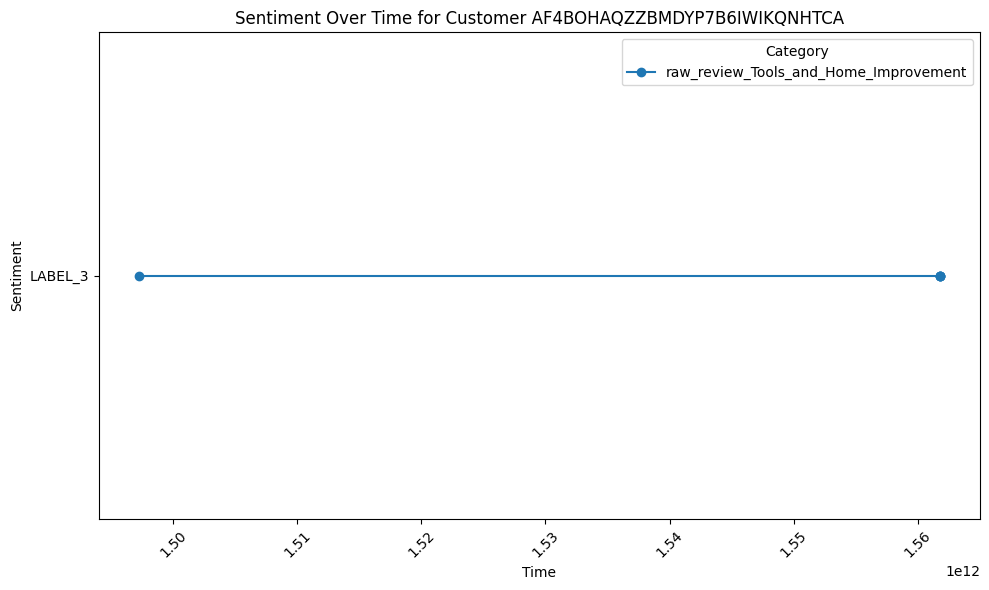

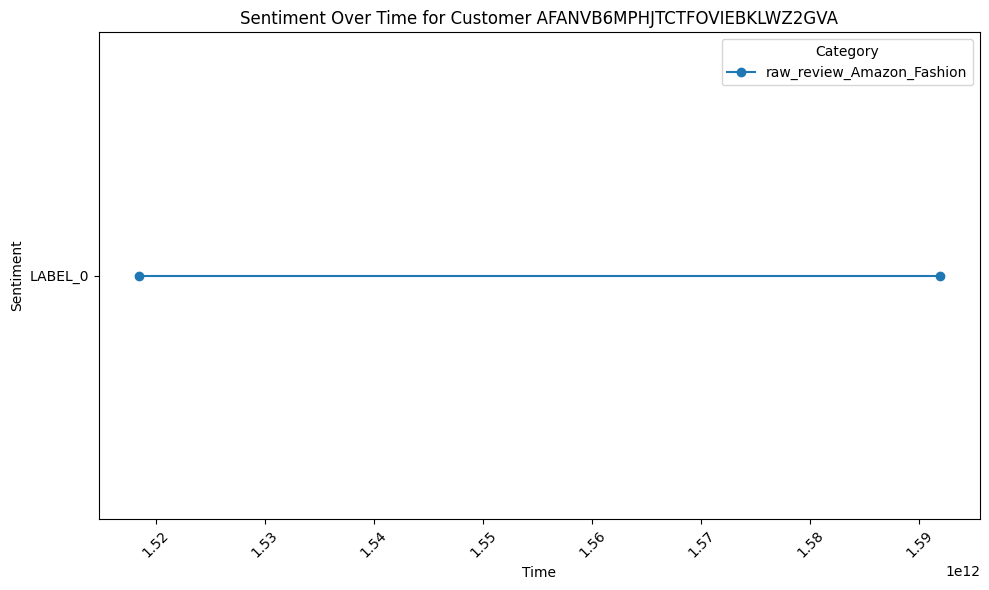

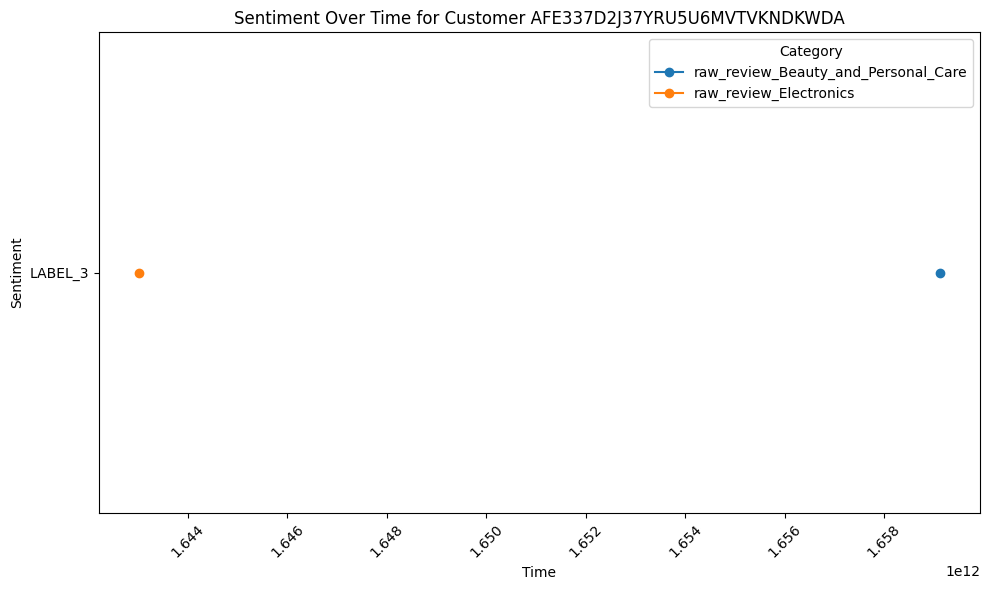

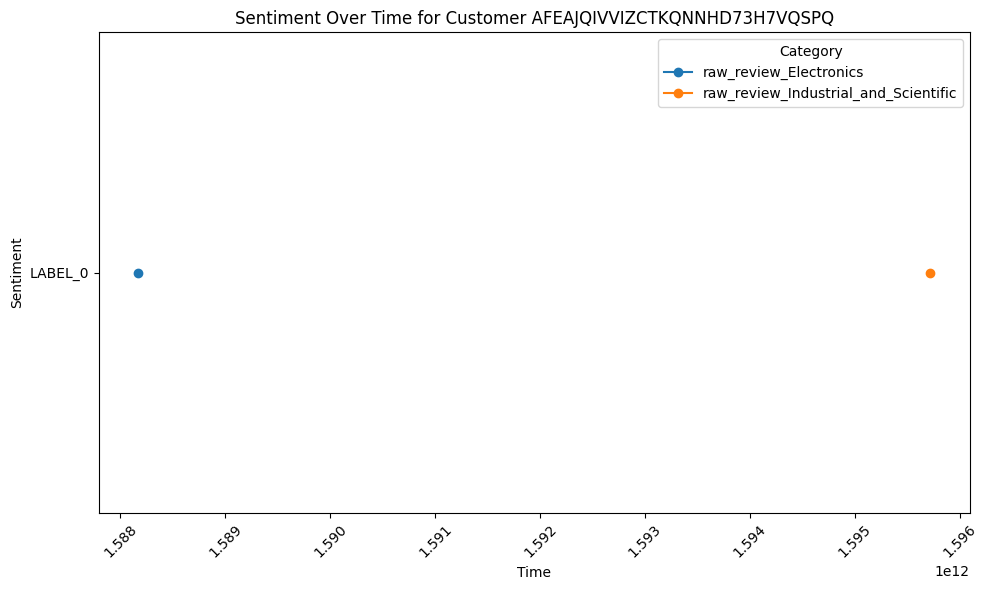

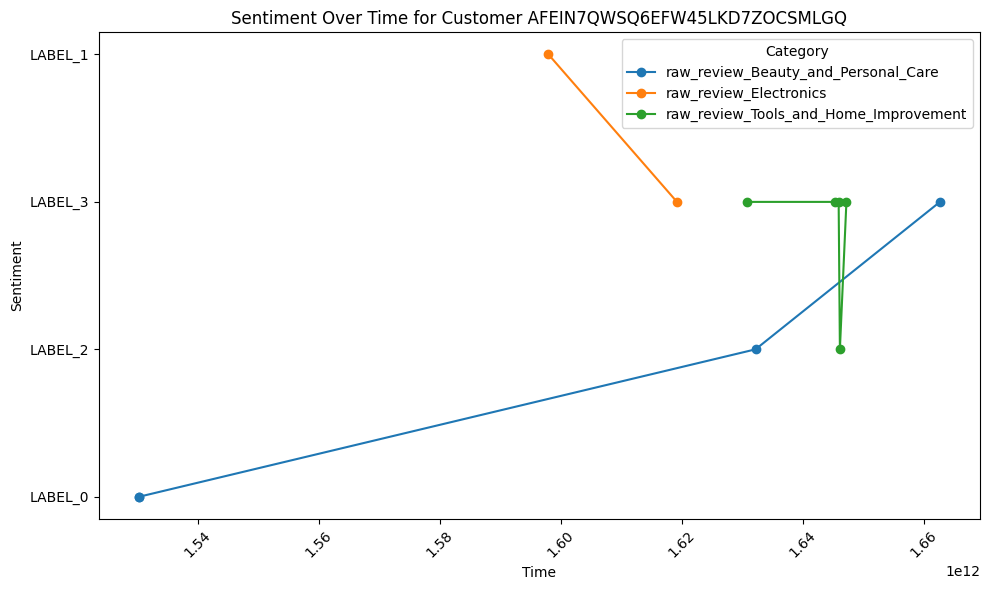

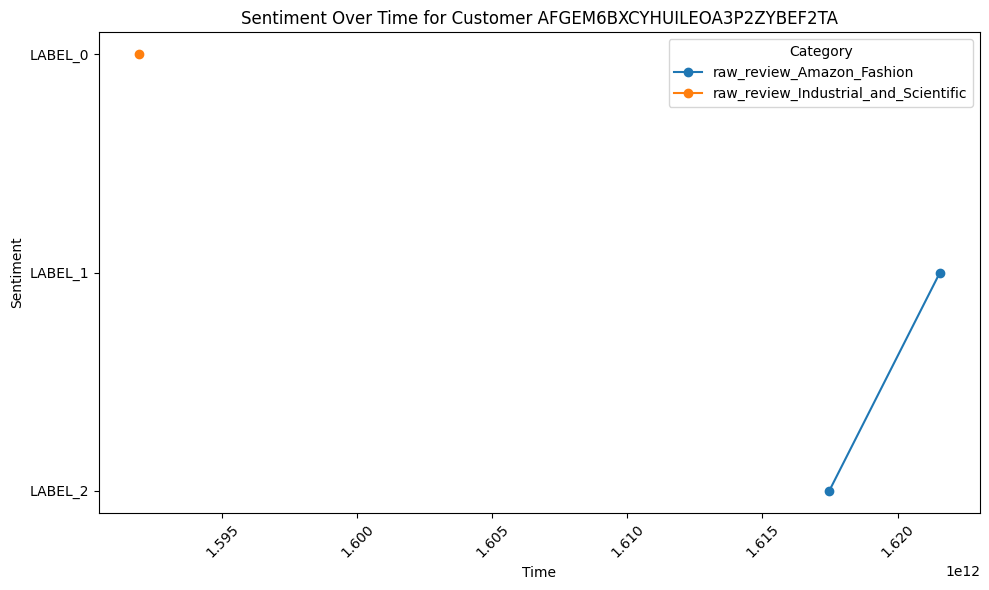

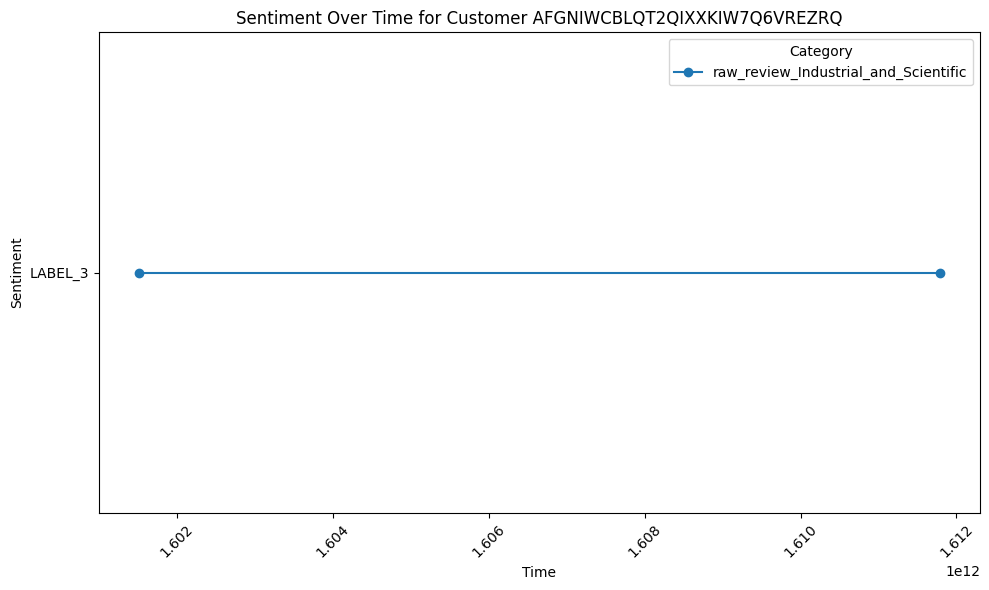

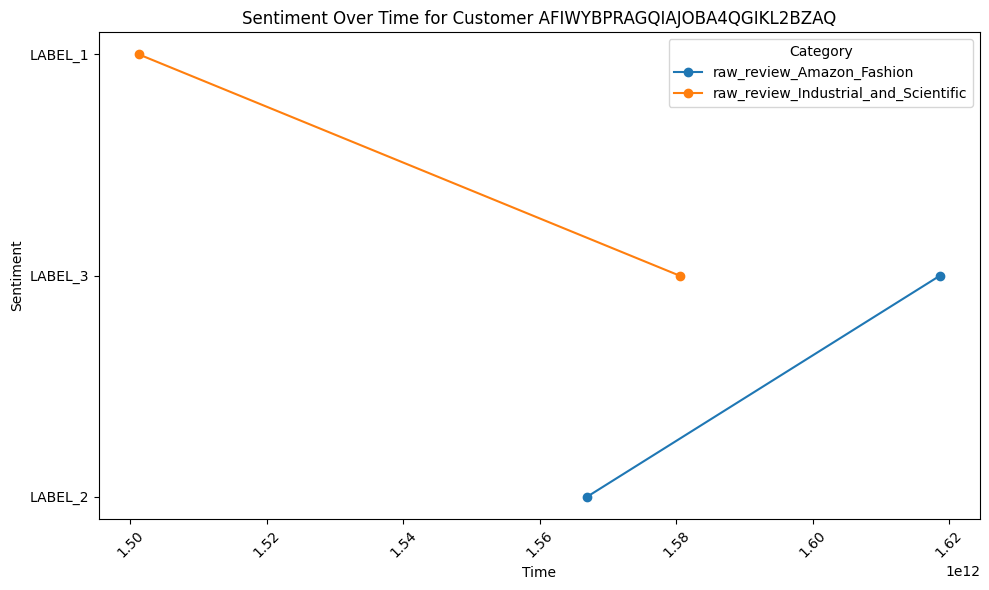

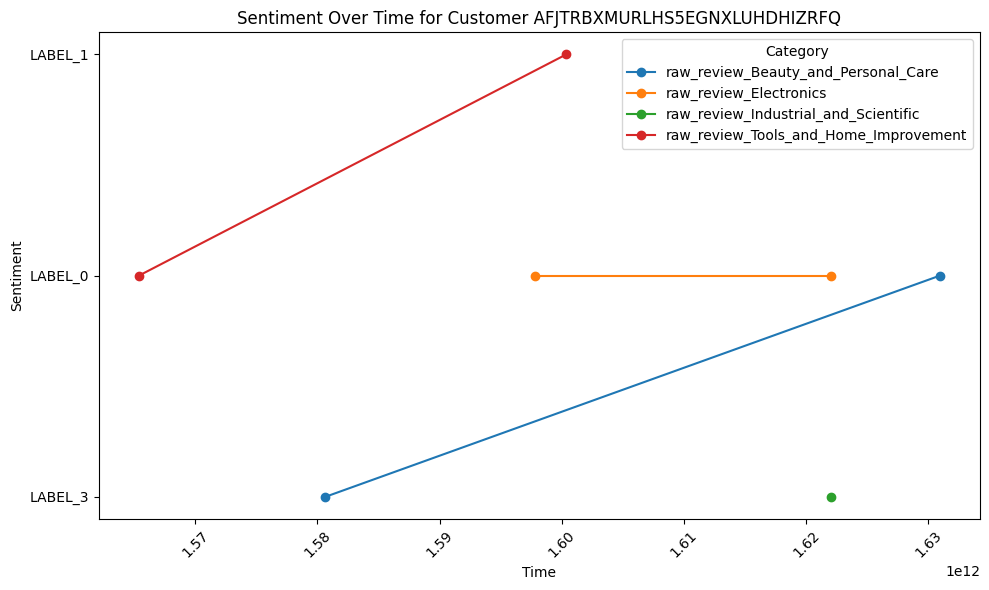

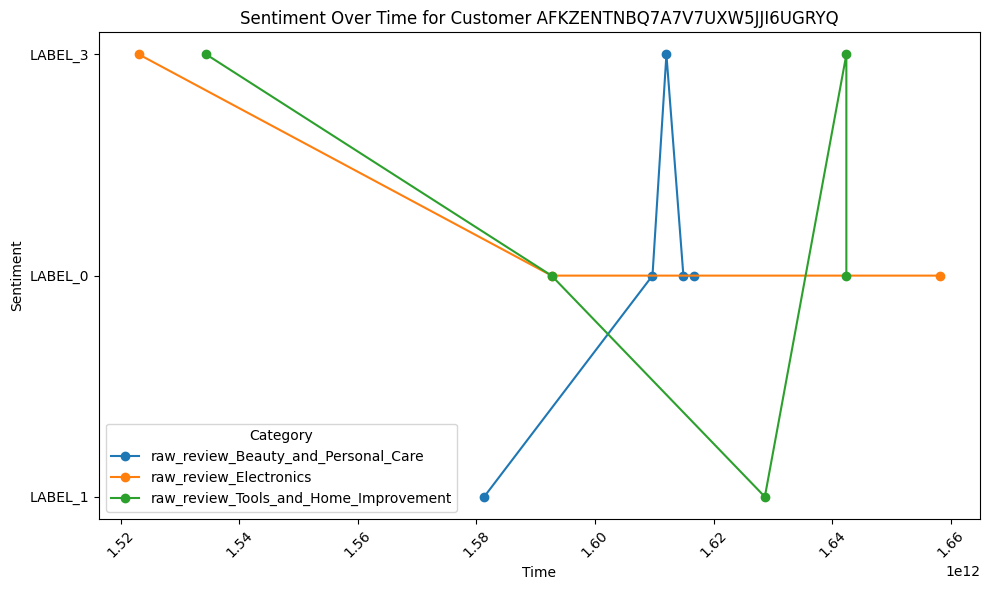

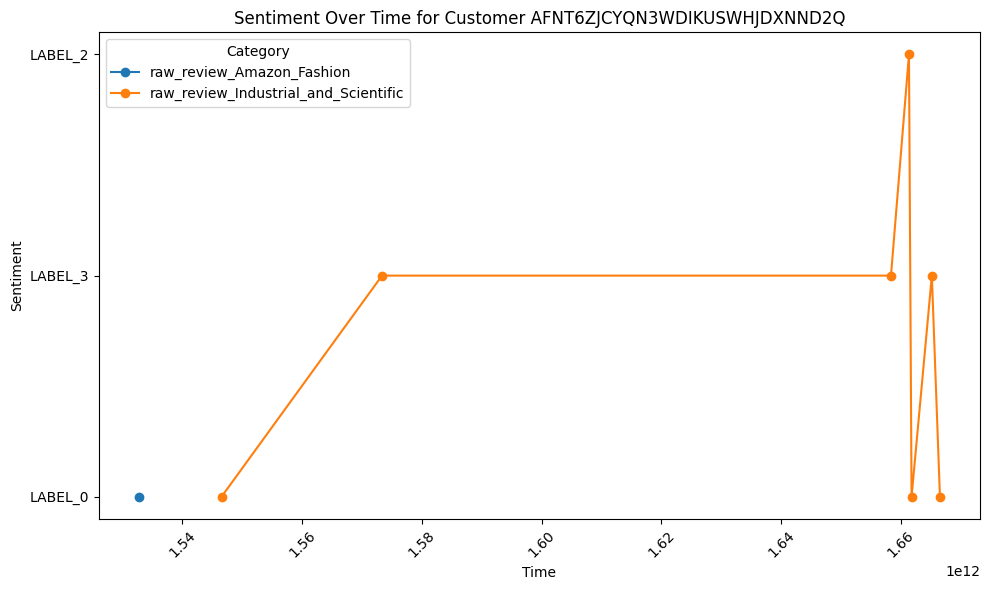

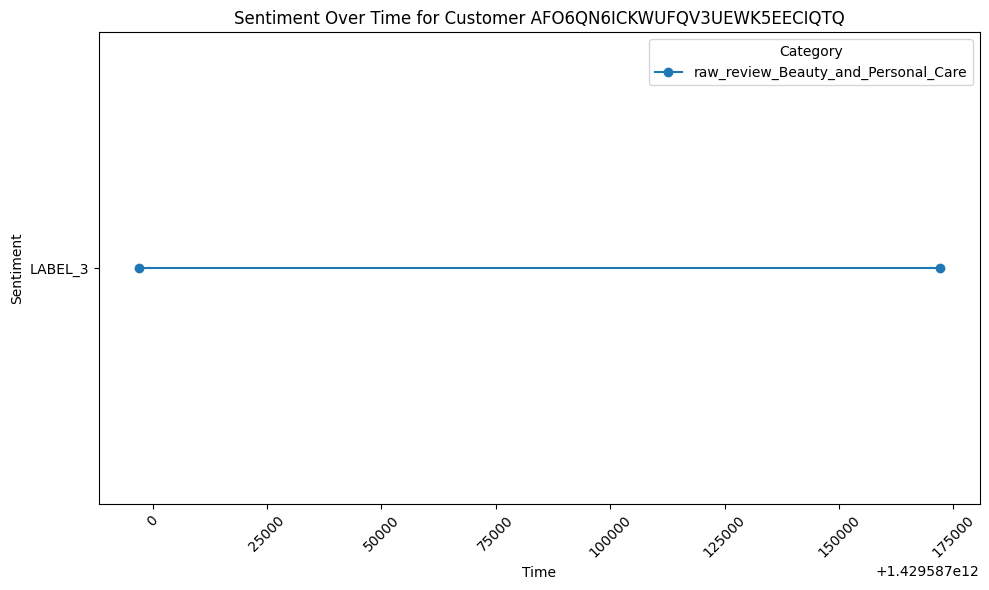

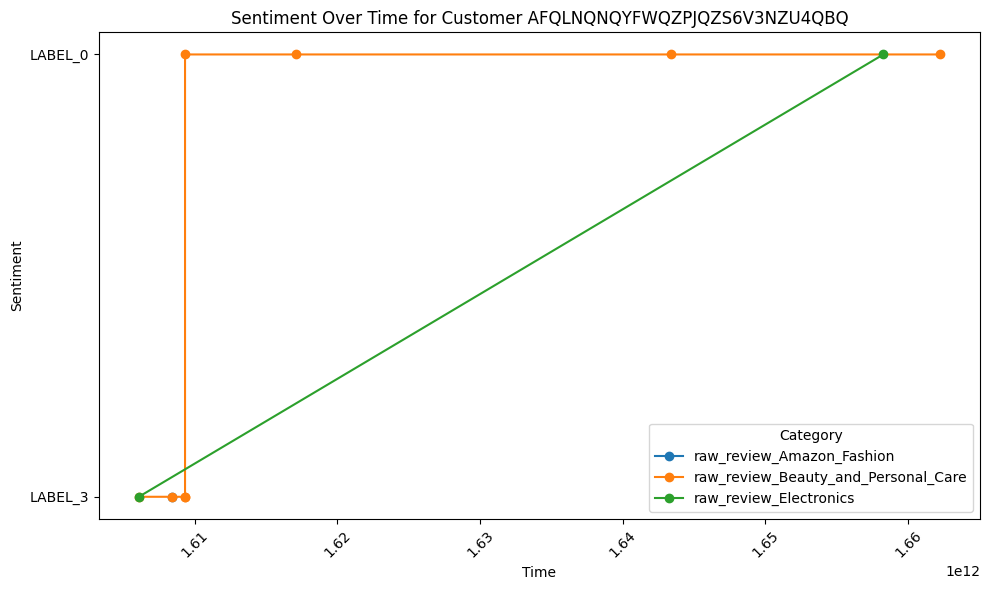

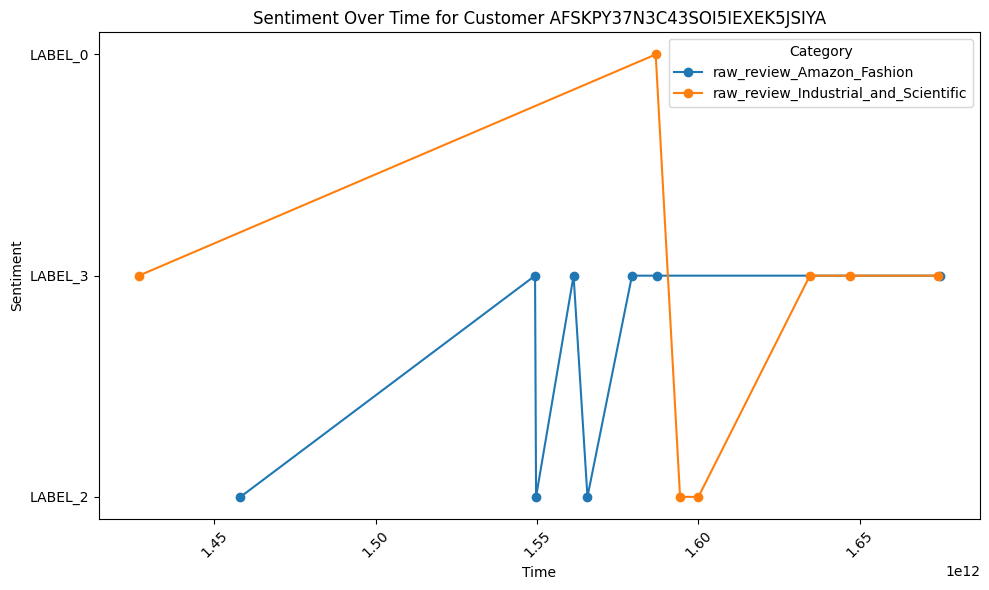

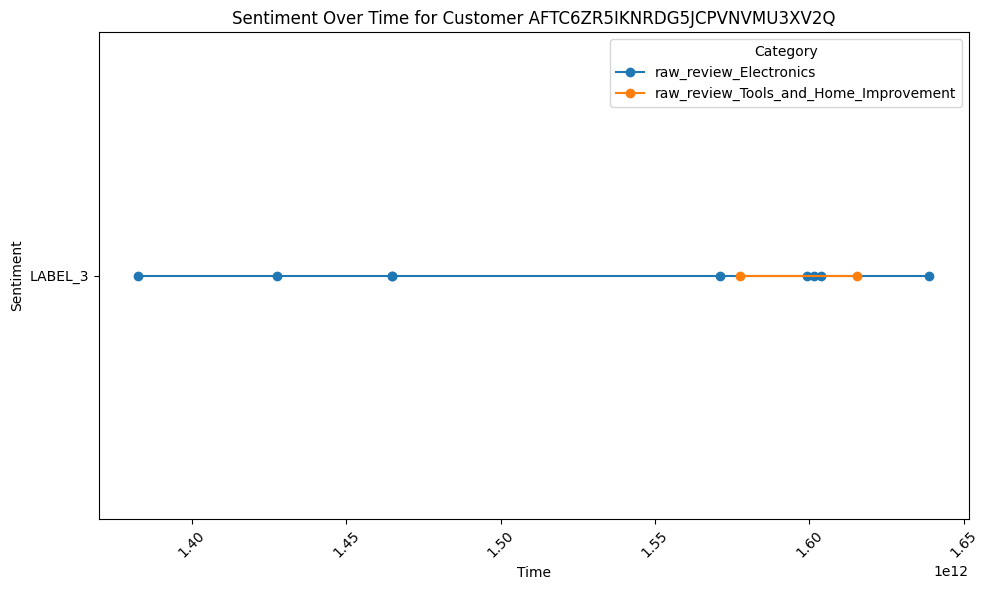

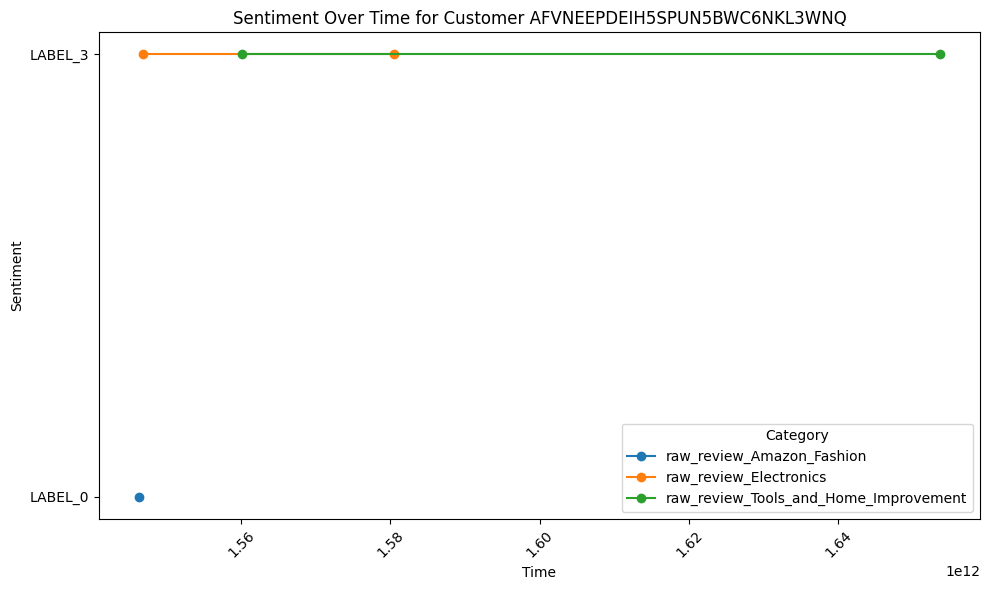

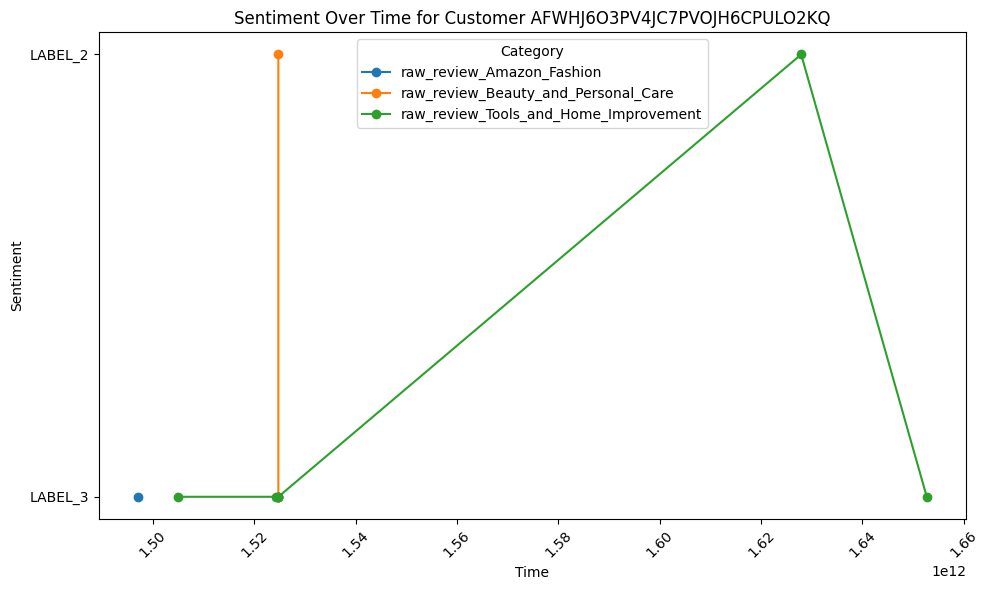

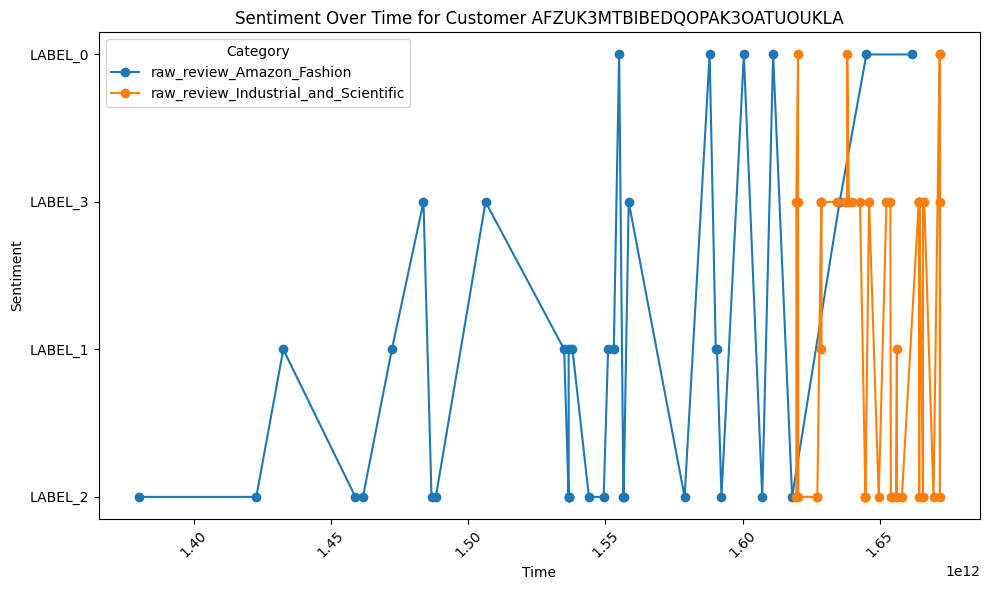

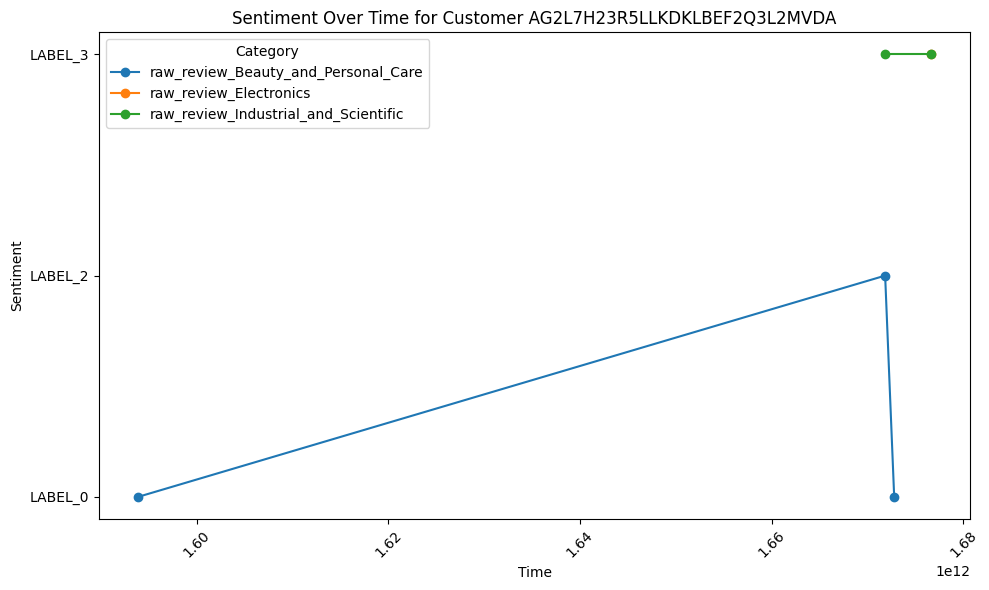

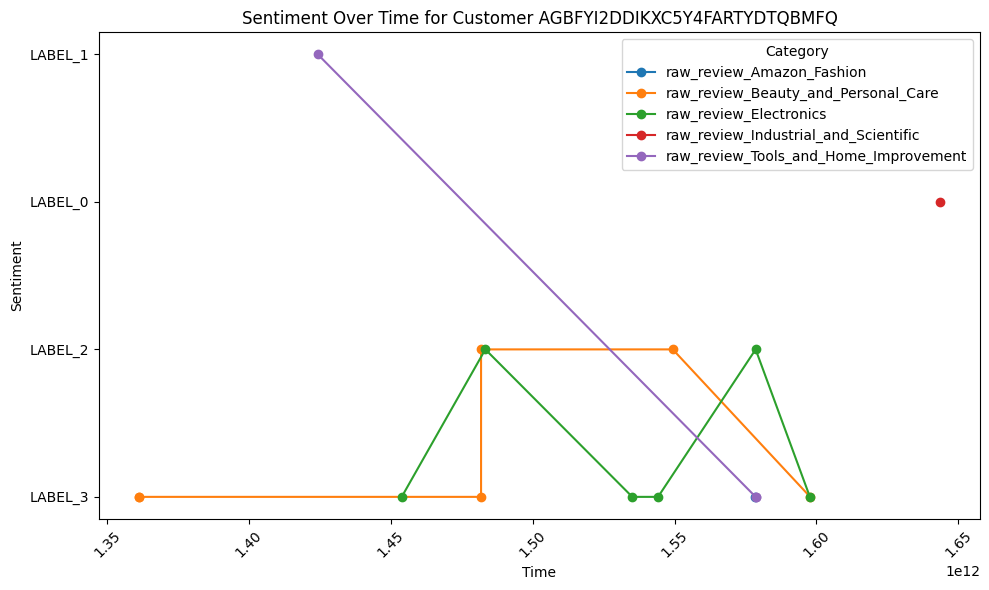

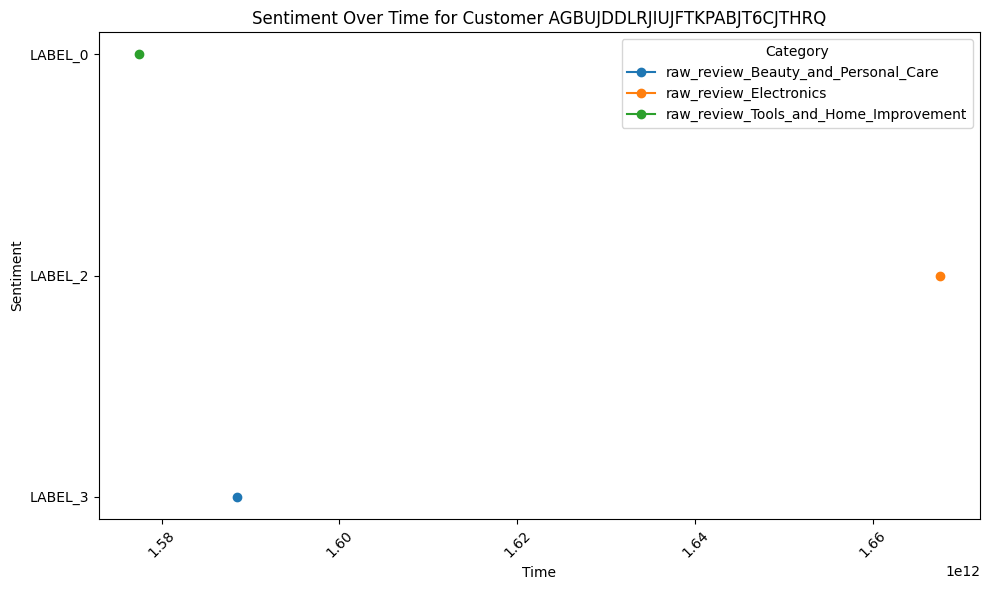

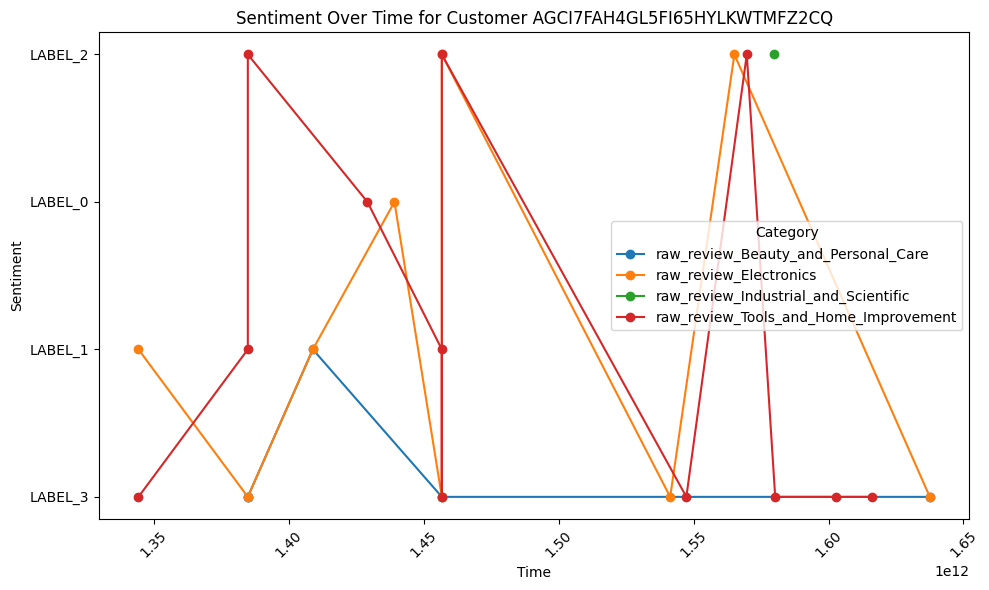

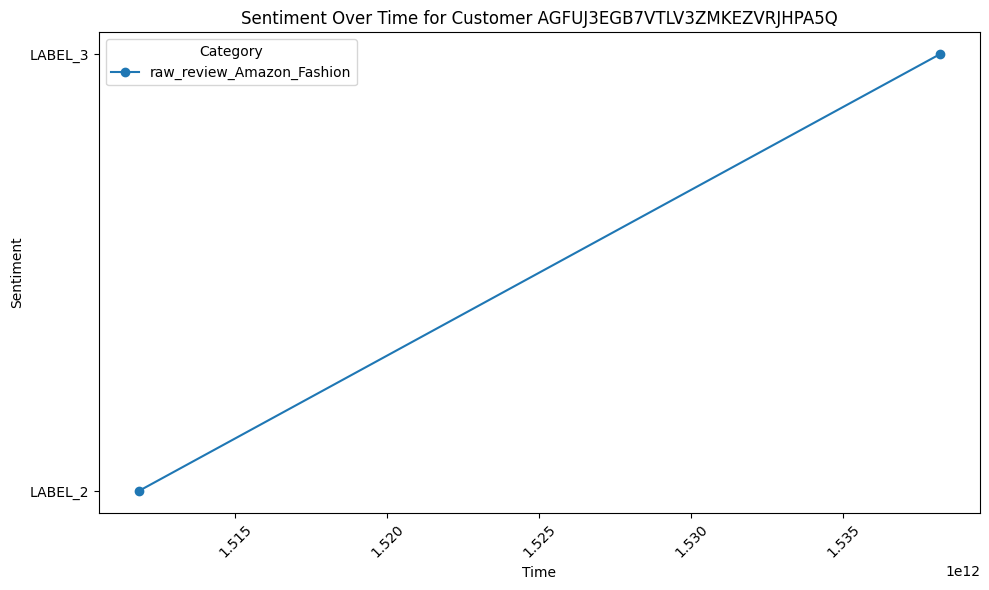

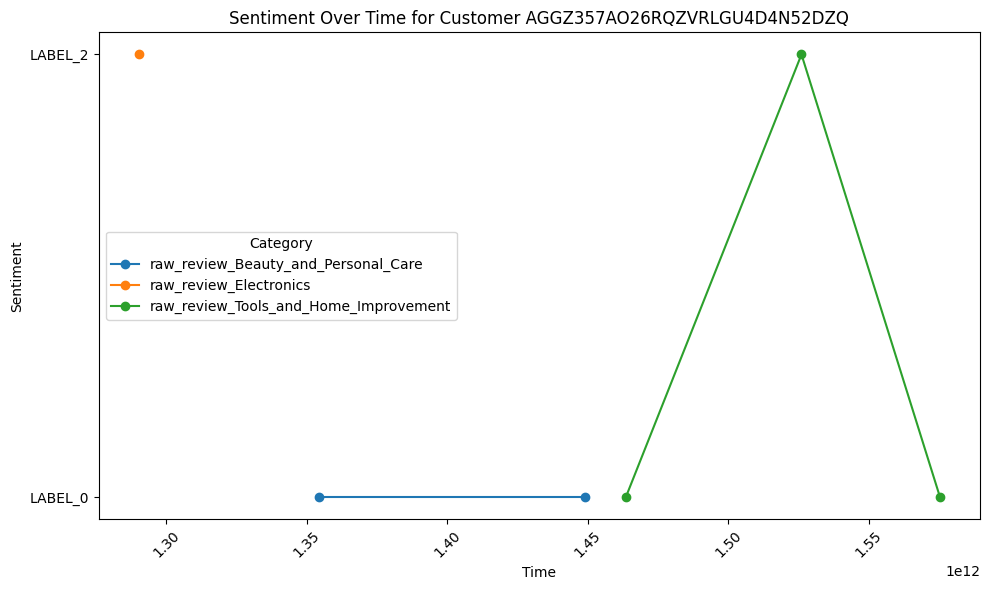

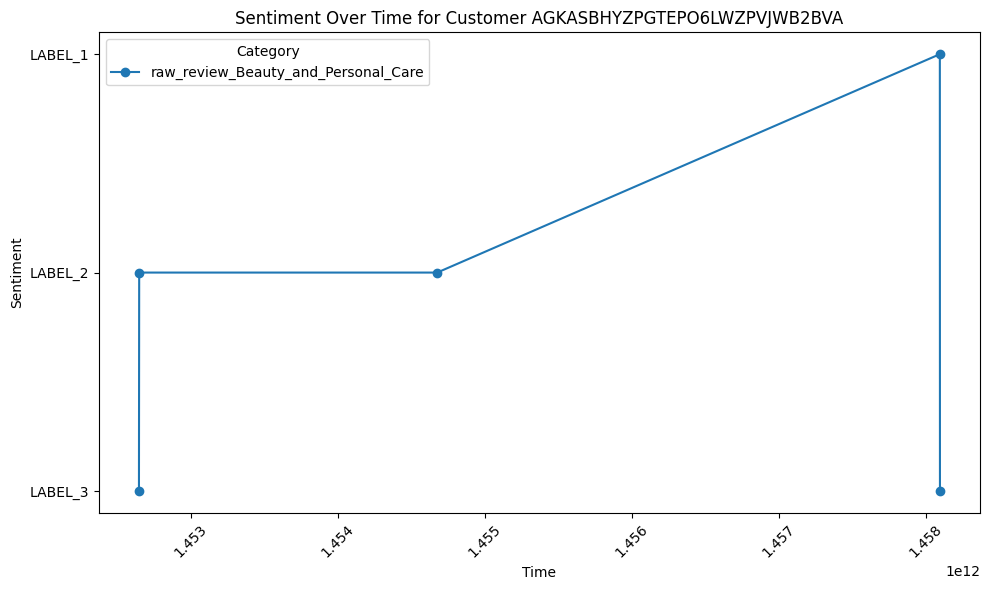

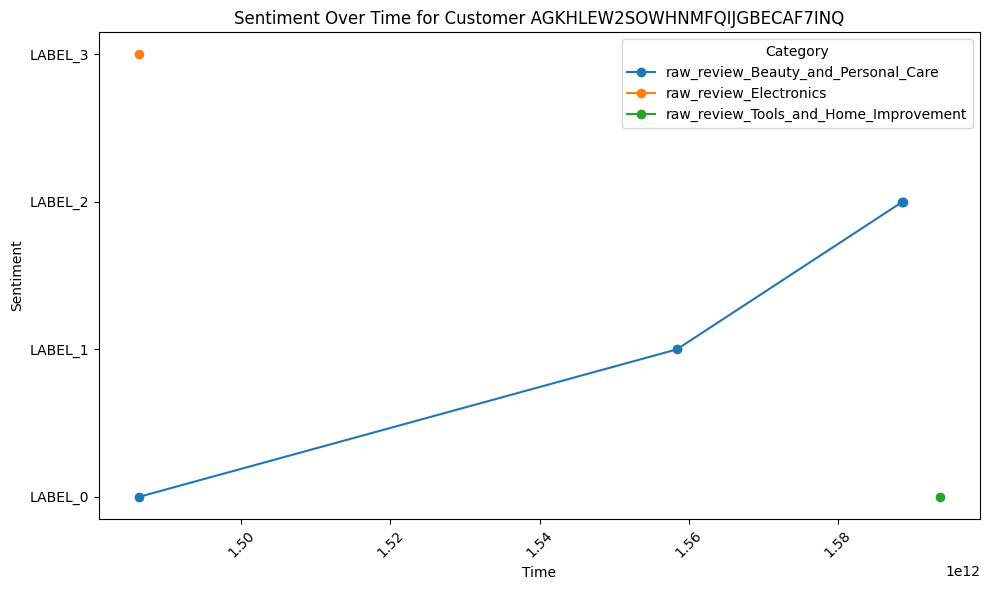

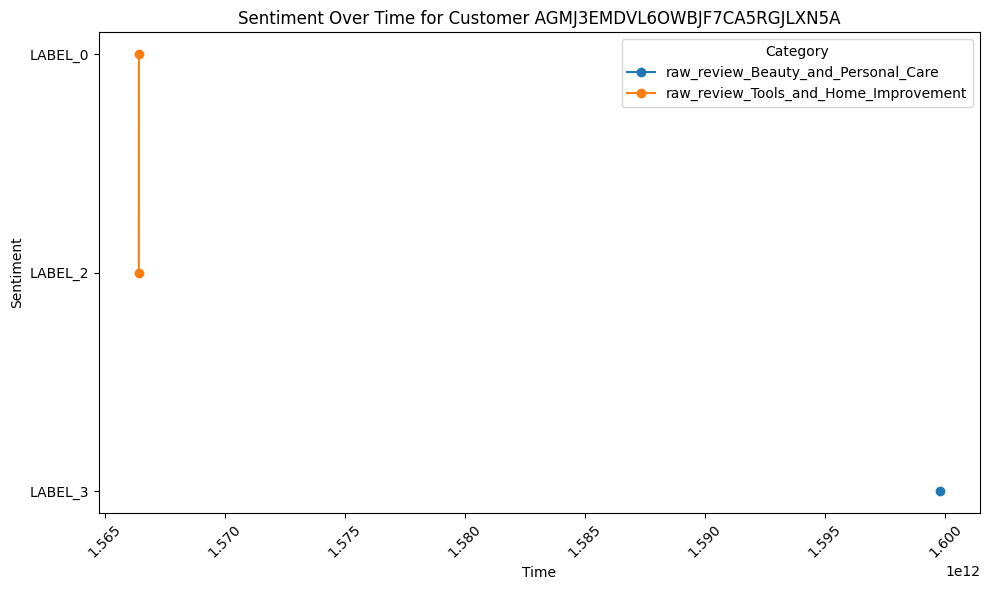

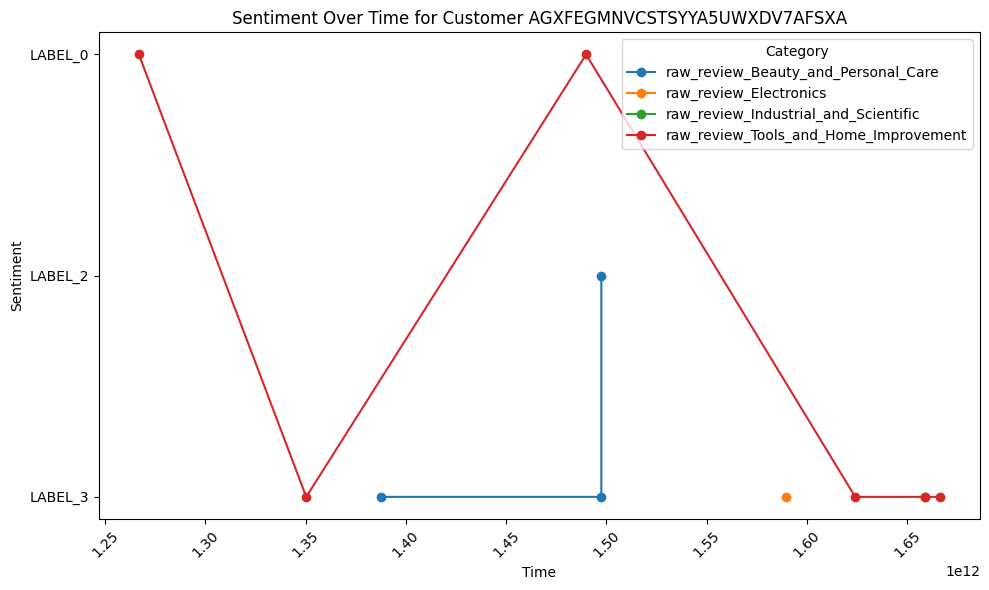

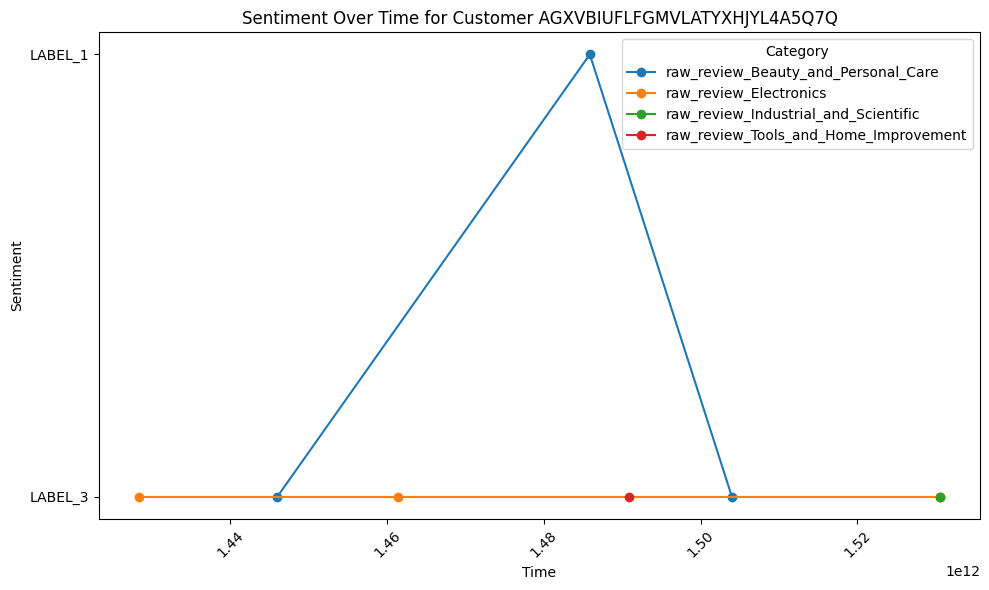

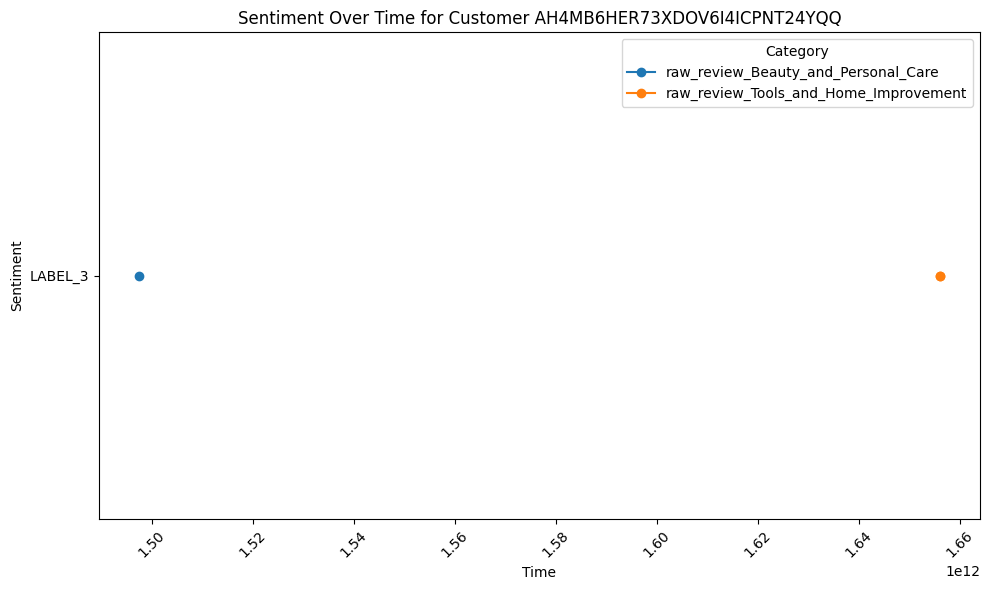

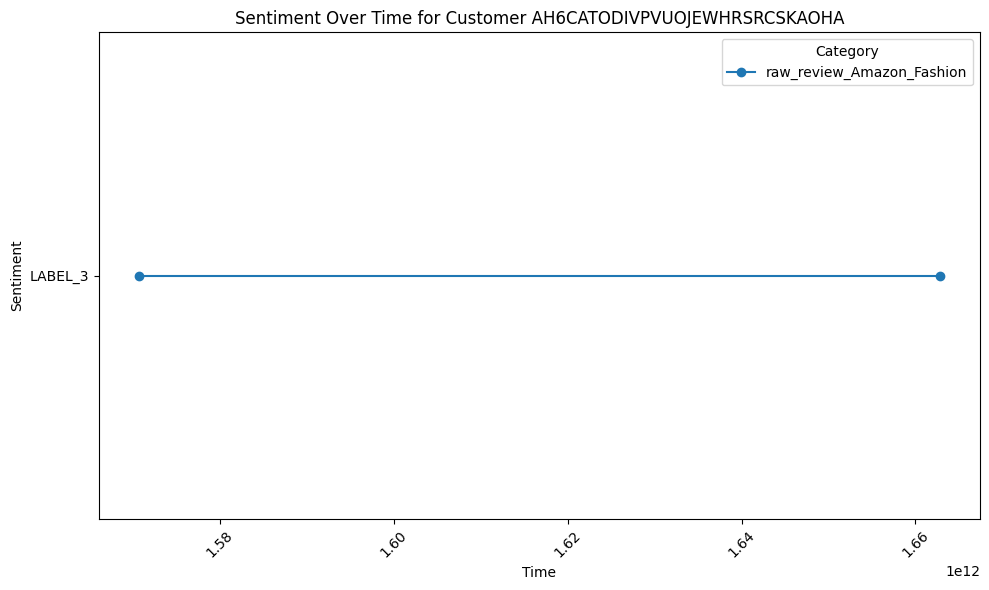

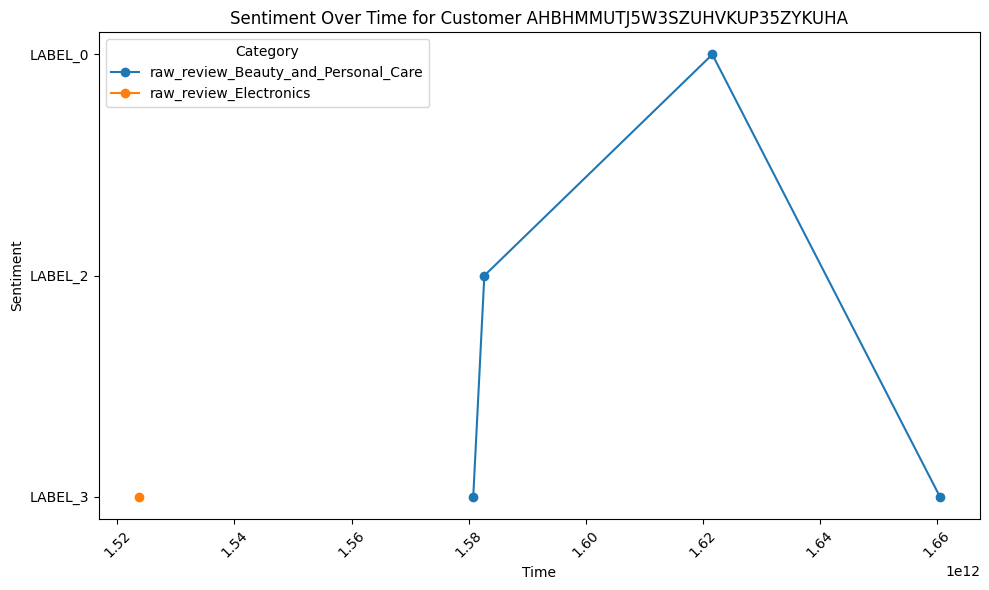

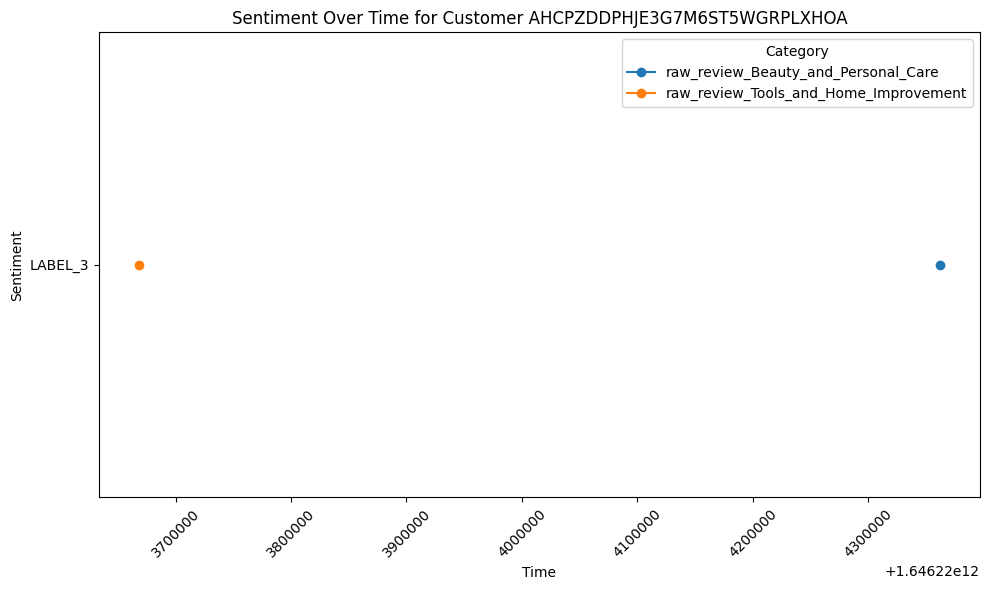

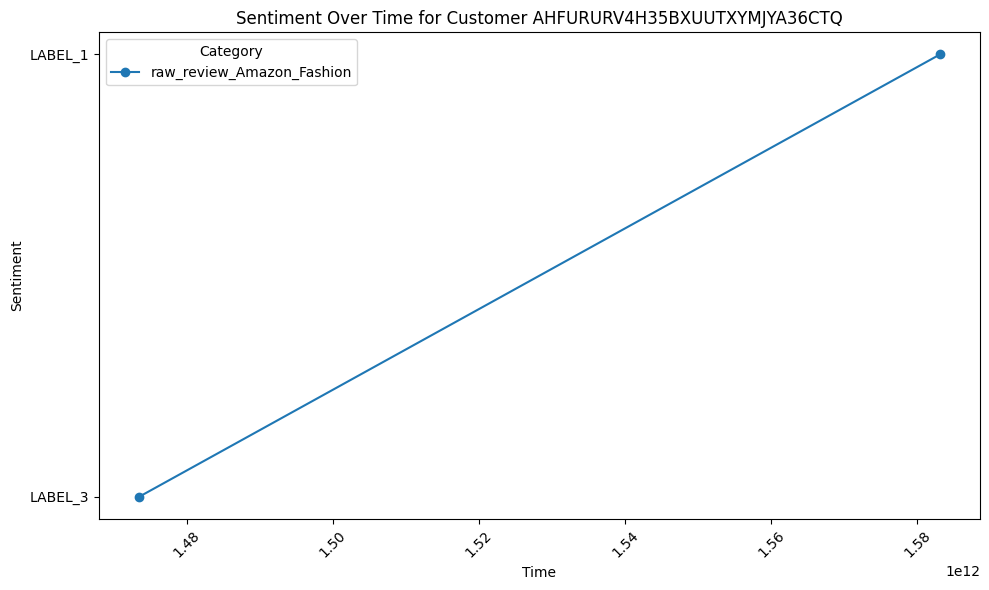

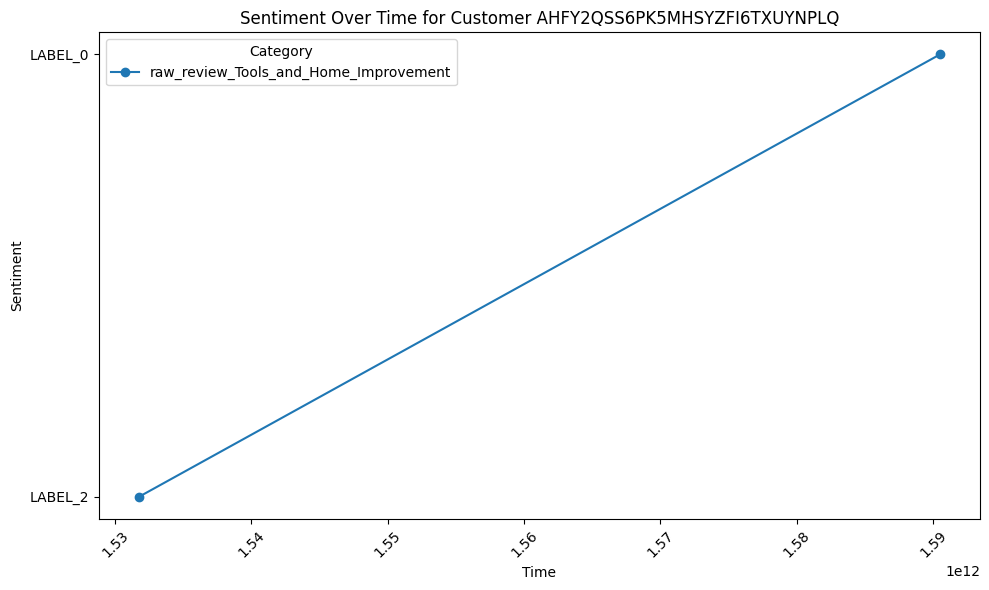

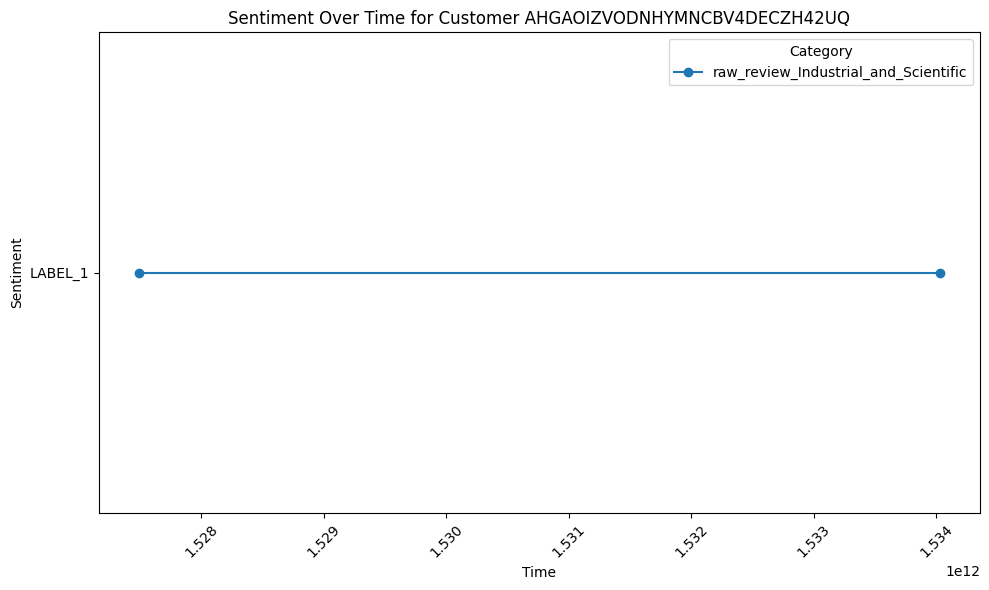

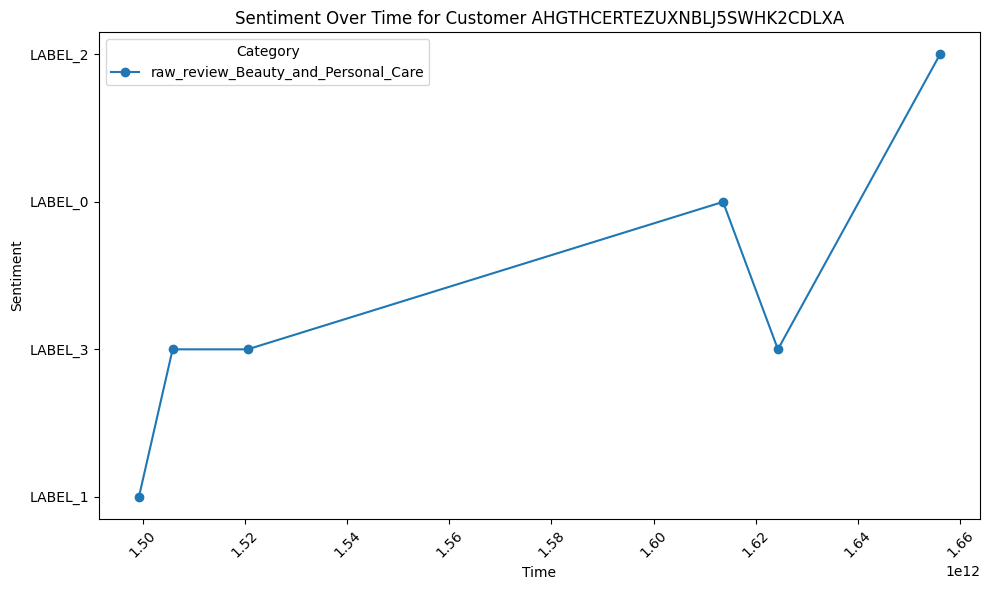

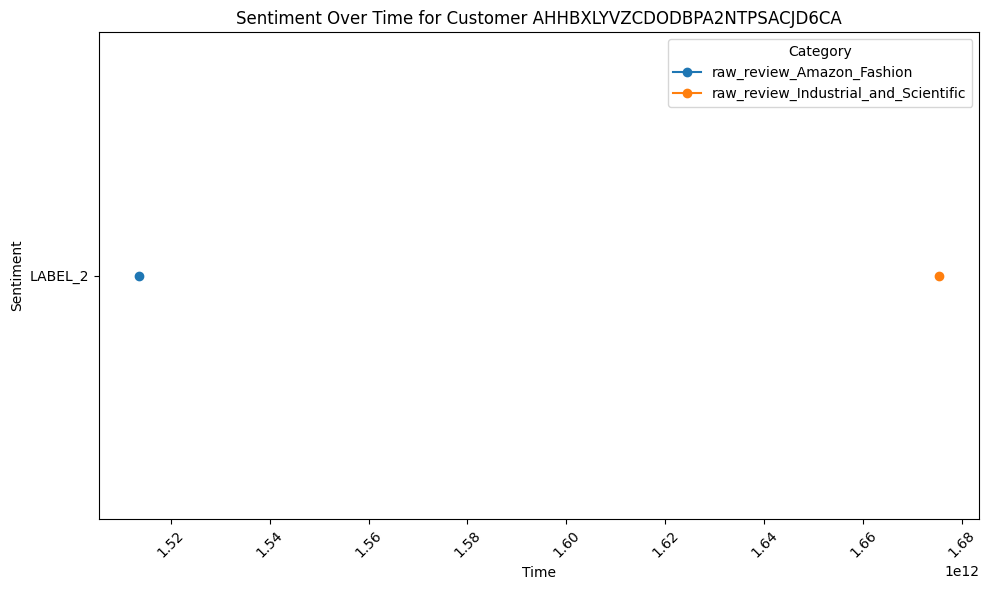

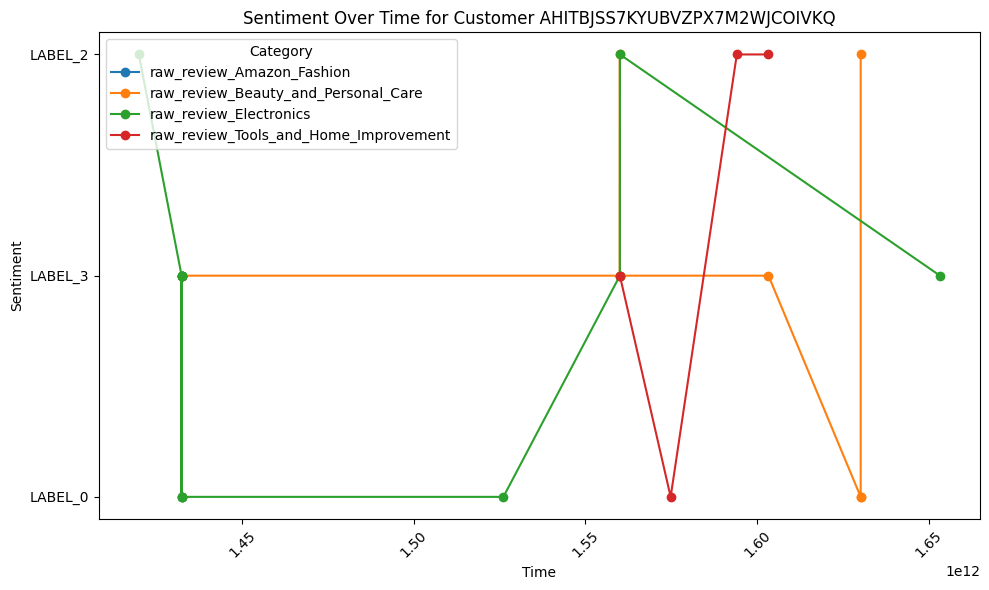

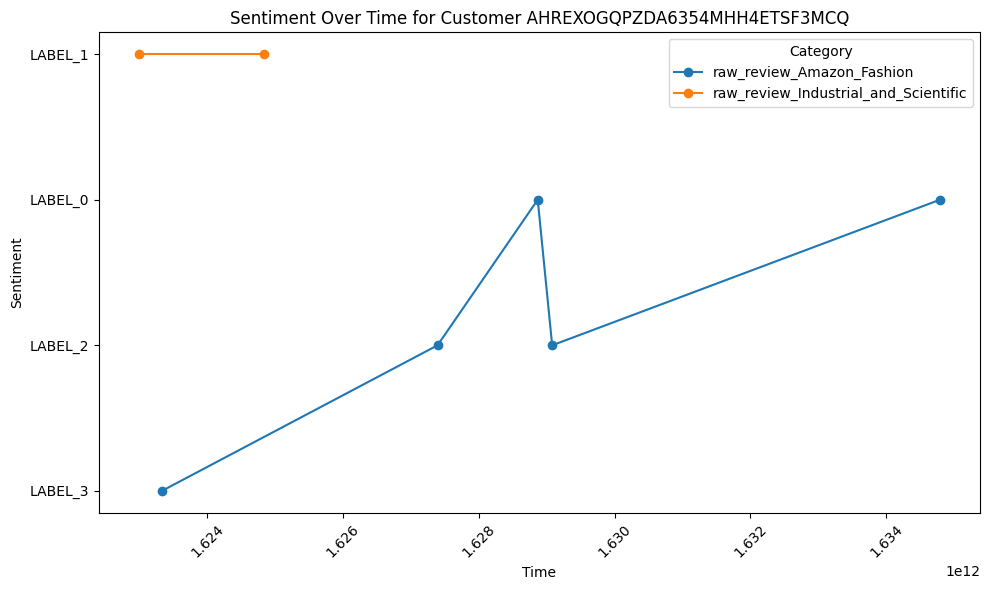

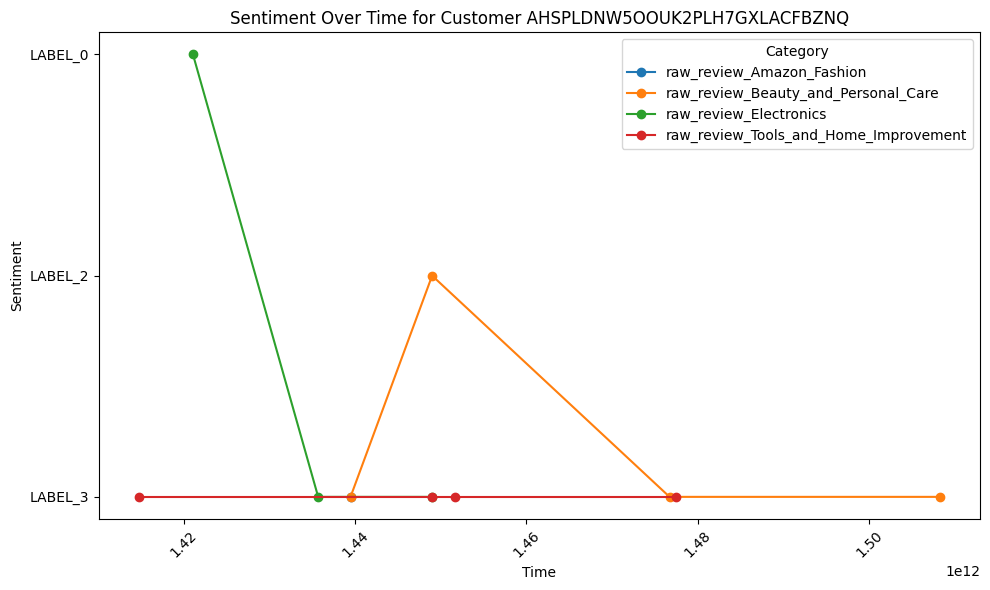

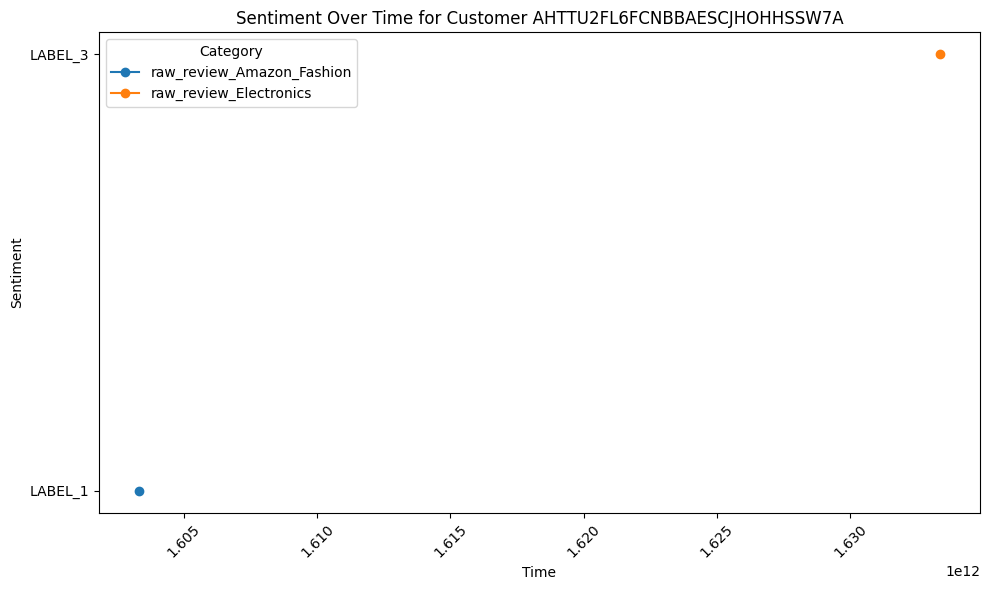

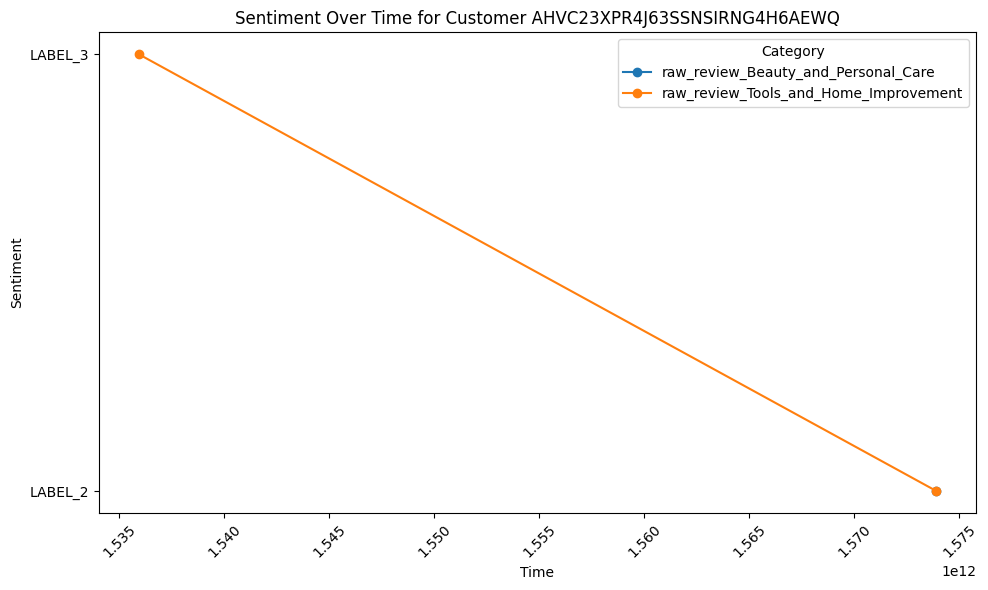

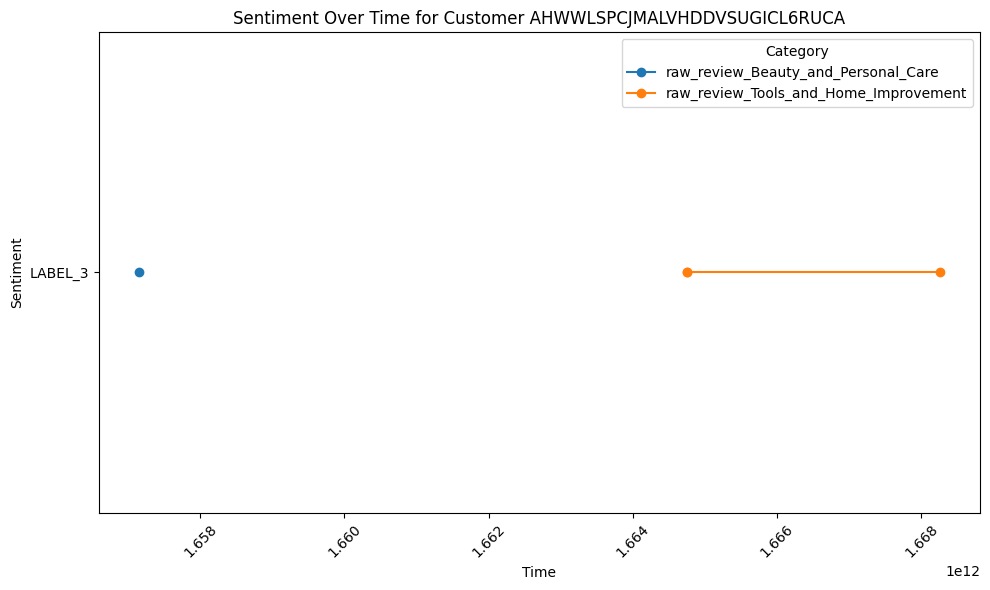

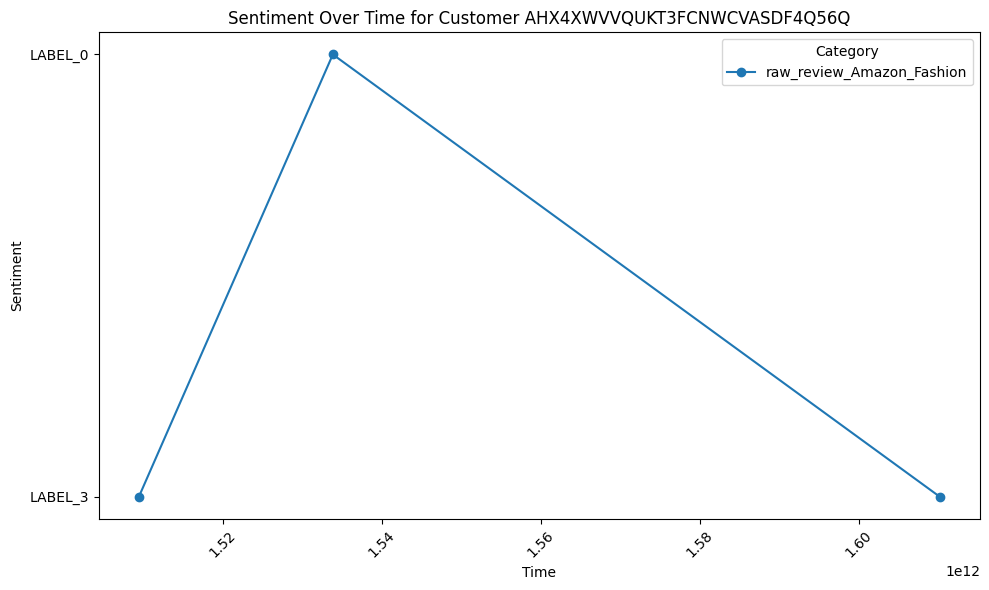

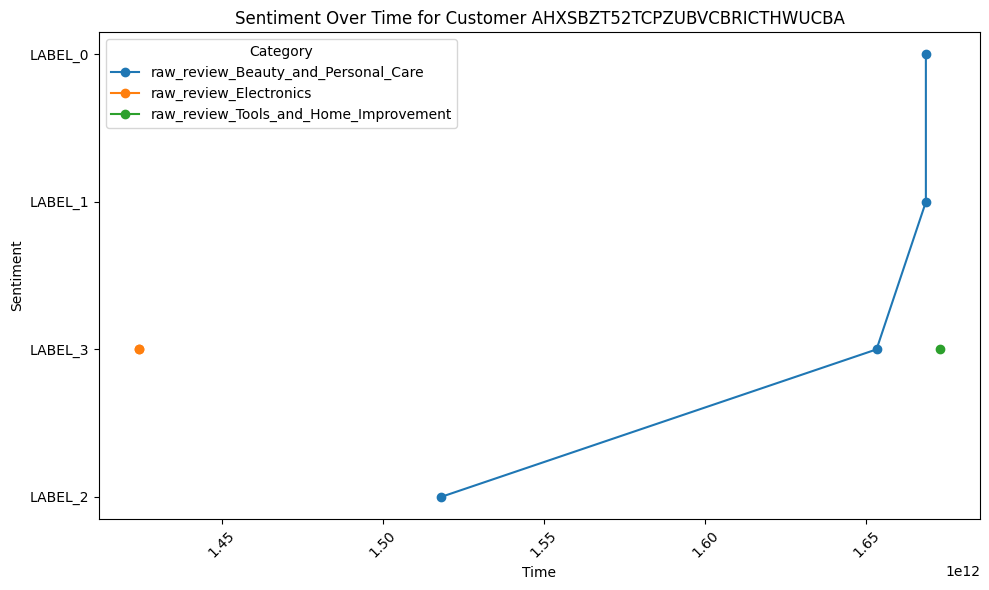

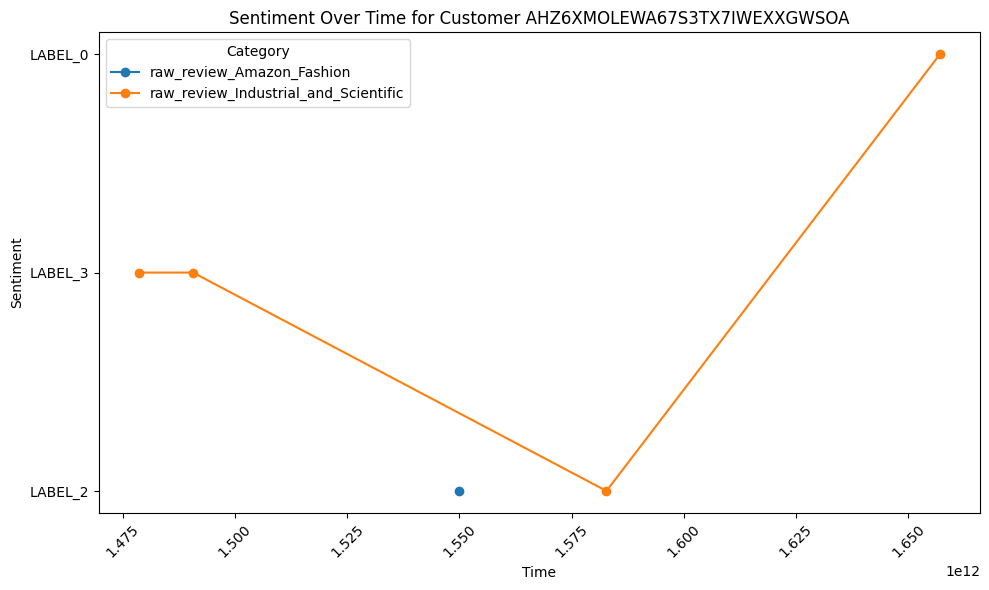

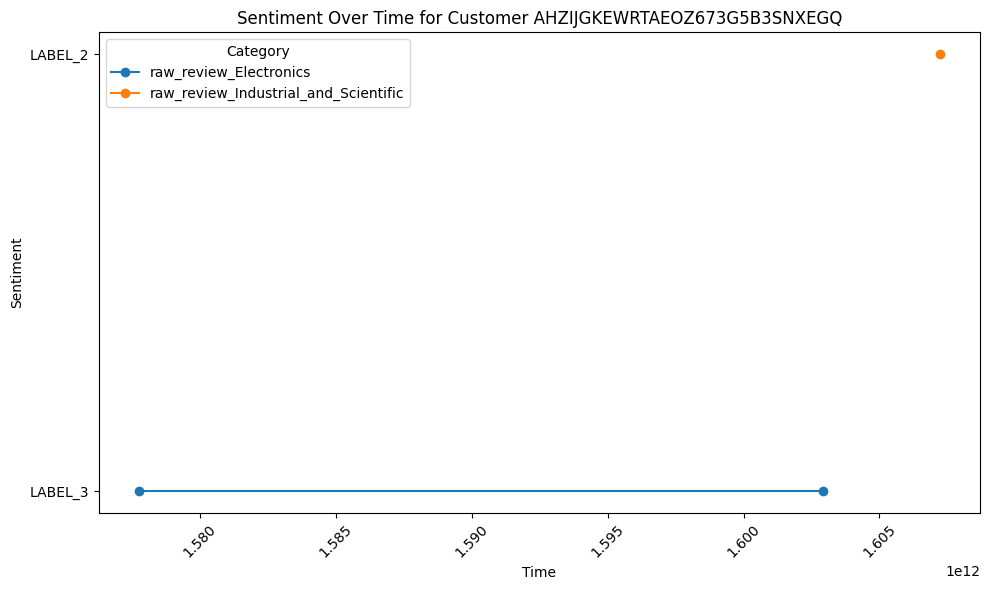

In [34]:
import matplotlib.pyplot as plt

# Müşteri ID ve zamanına göre grupla ve indeksi resetle
customer_reviews = data_df.groupby('user_id').apply(lambda x: x.sort_values('timestamp')).reset_index(drop=True)

# Birden fazla yorumu olan müşterileri filtrele
# 'user_id' artık sadece bir sütun olarak mevcut olacak
filtered_reviews = customer_reviews.groupby('user_id').filter(lambda x: len(x) > 1)

# Her müşteri için duygu durumlarının ve kategori bilgisinin grafiğini çiz
for customer_id, group in filtered_reviews.groupby('user_id'):
    plt.figure(figsize=(10, 6))

    # Her kategori için farklı bir renk ile çiz
    for category, category_group in group.groupby('category'):
        plt.plot(category_group['timestamp'], category_group['predicted_sentiment'], marker='o', linestyle='-', label=f"{category}")

    plt.title(f"Sentiment Over Time for Customer {customer_id}")
    plt.xlabel('Time')
    plt.ylabel('Sentiment')
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.tight_layout()
    plt.show()
